In [1]:
import os
import shutil
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, SimpleRNN, Dense, Conv1D, Dense, Flatten
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

2024-07-02 11:34:42.014407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# #URL dataset
# origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

# #Destination directory where you want to save the dataset
# dest_dir = '/Users/nfanlo/dev/technical-test/part2/data'
# if not os.path.exists(dest_dir):
#     os.makedirs(dest_dir)

# #Download the zip file and extract it
# zip_path = tf.keras.utils.get_file(
#     origin=origin,
#     fname=os.path.join(dest_dir, 'jena_climate_2009_2016.csv.zip'),
#     extract=True,
#     cache_dir=dest_dir)

# csv_path, _ = os.path.splitext(zip_path)

# print(f'CSV file downloaded and extracted to: {csv_path}')


## Description:

### Dataset Context:
Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

### Dataset Features:
- Date Time:	Date-time reference

- p (mbar): The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.

- T (degC): Temperature in Celsius.

- Tpot (K): Temperature in Kelvin.

- Tdew (degC): Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.

- rh (%): Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.

- VPmax (mbar): Saturation vapor pressure.

- VPact (mbar): Vapor pressure.

- VPdef (mbar): Vapor pressure deficit.

- sh (g/kg): Specific humidity.

- H2OC (mmol/mol): Water vapor concentration.

- rho (g/m ** 3): Airtight.

- wv (m/s): Wind speed.

- max. wv (m/s): Maximum wind speed.

- wd (deg): Wind direction in degrees

In [3]:
df = pd.read_csv('/Users/nfanlo/dev/technical-test/part2/data/datasets/jena_climate_2009_2016.csv')
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Establecer la columna 'Date Time' como índice
df.set_index('Date Time', inplace=True)

In [4]:
df.head(10)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   
2009-01-01 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
2009-01-01 01:10:00    996.50     -7.62    265.81        -8.30    94.8   
2009-01-01 01:20:00    996.50     -7.62    265.81        -8.36    94.4   
2009-01-01 01:30:00    996.50     -7.91    265.52        -8.73    93.8   
2009-01-01 01:40:00    996.53     -8.43    264.99        -9.34    93.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-01-01 00:50:00          3.27          3.08          0.19       1.92   
2009-01-01 01:00:00          3.33          3.14          0.19       1.96   
2009-01-01 01:10:00          3.44          3.26          0.18       2.04   
2009-01-01 01:20:00          3.44          3.25          0.19       2.03   
2009-01-01 01:30:00          3.36          3.15          0.21       1.97   
2009-01-01 01:40:00          3.23          3.00          0.22       1.88   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   
2009-01-01 00:30:00             3.02       1310.24      0.19           0.63   
2009-01-01 00:40:00             3.08       1309.19      0.34           0.50   
2009-01-01 00:50:00             3.09       1309.00      0.32           0.63   
2009-01-01 01:00:00             3.15       1307.86      0.21           0.63   
2009-01-01 01:10:00             3.27       1305.68      0.18           0.63   
2009-01-01 01:20:00             3.26       1305.69      0.19           0.50   
2009-01-01 01:30:00             3.16       1307.17      0.28           0.75   
2009-01-01 01:40:00             3.02       1309.85      0.59           0.88   

                     wd (deg)  
Date Time                      
2009-01-01 00:10:00     152.3  
2009-01-01 00:20:00     136.1  
2009-01-01 00:30:00     171.6  
2009-01-01 00:40:00     198.0  
2009-01-01 00:50:00     214.3  
2009-01-01 01:00:00     192.7  
2009-01-01 01:10:00     166.5  
2009-01-01 01:20:00     118.6  
2009-01-01 01:30:00     188.5  
2009-01-01 01:40:00     185.0

In [5]:
df.shape

(420551, 14)

In [6]:
#Resample dataset to years
df = df[5::6]
df.shape

(70091, 14)

In [7]:
df.head(10)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
2009-01-01 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
2009-01-01 03:00:00    996.84     -8.81    264.59        -9.66    93.5   
2009-01-01 04:00:00    996.99     -9.05    264.34       -10.02    92.6   
2009-01-01 05:00:00    997.46     -9.63    263.72       -10.65    92.2   
2009-01-01 06:00:00    997.71     -9.67    263.66       -10.62    92.7   
2009-01-01 07:00:00    998.33     -9.17    264.12       -10.10    92.9   
2009-01-01 08:00:00    999.17     -8.10    265.12        -9.05    92.8   
2009-01-01 09:00:00    999.69     -7.66    265.52        -8.84    91.2   
2009-01-01 10:00:00   1000.27     -7.04    266.10        -8.17    91.6   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 01:00:00          3.33          3.14          0.19       1.96   
2009-01-01 02:00:00          3.12          2.90          0.21       1.81   
2009-01-01 03:00:00          3.13          2.93          0.20       1.83   
2009-01-01 04:00:00          3.07          2.85          0.23       1.78   
2009-01-01 05:00:00          2.94          2.71          0.23       1.69   
2009-01-01 06:00:00          2.93          2.71          0.21       1.69   
2009-01-01 07:00:00          3.04          2.83          0.22       1.76   
2009-01-01 08:00:00          3.31          3.07          0.24       1.92   
2009-01-01 09:00:00          3.43          3.13          0.30       1.95   
2009-01-01 10:00:00          3.60          3.30          0.30       2.05   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 01:00:00             3.15       1307.86      0.21           0.63   
2009-01-01 02:00:00             2.91       1312.25      0.25           0.63   
2009-01-01 03:00:00             2.94       1312.18      0.18           0.63   
2009-01-01 04:00:00             2.85       1313.61      0.10           0.38   
2009-01-01 05:00:00             2.71       1317.19      0.40           0.88   
2009-01-01 06:00:00             2.72       1317.71      0.05           0.50   
2009-01-01 07:00:00             2.83       1315.98      2.08           2.88   
2009-01-01 08:00:00             3.08       1311.65      0.72           1.25   
2009-01-01 09:00:00             3.13       1310.14      0.34           0.63   
2009-01-01 10:00:00             3.29       1307.76      1.45           3.00   

                     wd (deg)  
Date Time                      
2009-01-01 01:00:00     192.7  
2009-01-01 02:00:00     190.3  
2009-01-01 03:00:00     167.2  
2009-01-01 04:00:00     240.0  
2009-01-01 05:00:00     157.0  
2009-01-01 06:00:00     146.0  
2009-01-01 07:00:00     348.8  
2009-01-01 08:00:00     213.9  
2009-01-01 09:00:00     202.2  
2009-01-01 10:00:00     292.6

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70091 entries, 2009-01-01 01:00:00 to 2016-12-31 23:10:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         70091 non-null  float64
 1   T (degC)         70091 non-null  float64
 2   Tpot (K)         70091 non-null  float64
 3   Tdew (degC)      70091 non-null  float64
 4   rh (%)           70091 non-null  float64
 5   VPmax (mbar)     70091 non-null  float64
 6   VPact (mbar)     70091 non-null  float64
 7   VPdef (mbar)     70091 non-null  float64
 8   sh (g/kg)        70091 non-null  float64
 9   H2OC (mmol/mol)  70091 non-null  float64
 10  rho (g/m**3)     70091 non-null  float64
 11  wv (m/s)         70091 non-null  float64
 12  max. wv (m/s)    70091 non-null  float64
 13  wd (deg)         70091 non-null  float64
dtypes: float64(14)
memory usage: 8.0 MB


In [9]:
nan_counts = df.isna().sum()
print(nan_counts)

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


In [10]:
df.describe().transpose()

count         mean        std      min      25%      50%  \
p (mbar)         70091.0   989.212842   8.358886   913.60   984.20   989.57   
T (degC)         70091.0     9.450482   8.423384   -22.76     3.35     9.41   
Tpot (K)         70091.0   283.493086   8.504424   250.85   277.44   283.46   
Tdew (degC)      70091.0     4.956471   6.730081   -24.80     0.24     5.21   
rh (%)           70091.0    76.009788  16.474920    13.88    65.21    79.30   
VPmax (mbar)     70091.0    13.576576   7.739883     0.97     7.77    11.82   
VPact (mbar)     70091.0     9.533968   4.183658     0.81     6.22     8.86   
VPdef (mbar)     70091.0     4.042536   4.898549     0.00     0.87     2.19   
sh (g/kg)        70091.0     6.022560   2.655812     0.51     3.92     5.59   
H2OC (mmol/mol)  70091.0     9.640437   4.234862     0.81     6.29     8.96   
rho (g/m**3)     70091.0  1216.061232  39.974263  1059.45  1187.47  1213.80   
wv (m/s)         70091.0     1.702567  65.447512 -9999.00     0.99     1.76   
max. wv (m/s)    70091.0     2.963041  75.597657 -9999.00     1.76     2.98   
wd (deg)         70091.0   174.789095  86.619431     0.00   125.30   198.10   

                      75%      max  
p (mbar)          994.720  1015.29  
T (degC)           15.480    37.28  
Tpot (K)          289.530   311.21  
Tdew (degC)        10.080    23.06  
rh (%)             89.400   100.00  
VPmax (mbar)       17.610    63.77  
VPact (mbar)       12.360    28.25  
VPdef (mbar)        5.300    46.01  
sh (g/kg)           7.800    18.07  
H2OC (mmol/mol)    12.490    28.74  
rho (g/m**3)     1242.765  1393.54  
wv (m/s)            2.860    14.01  
max. wv (m/s)       4.740    23.50  
wd (deg)          234.000   360.00

In [11]:
#Replace values ​​-9999.0 with 0.0 in columns 'wv (m/s)' and 'max. wv (m/s)'
df['wv (m/s)'].replace(-9999.0, 0.0, inplace=True)
df['max. wv (m/s)'].replace(-9999.0, 0.0, inplace=True)

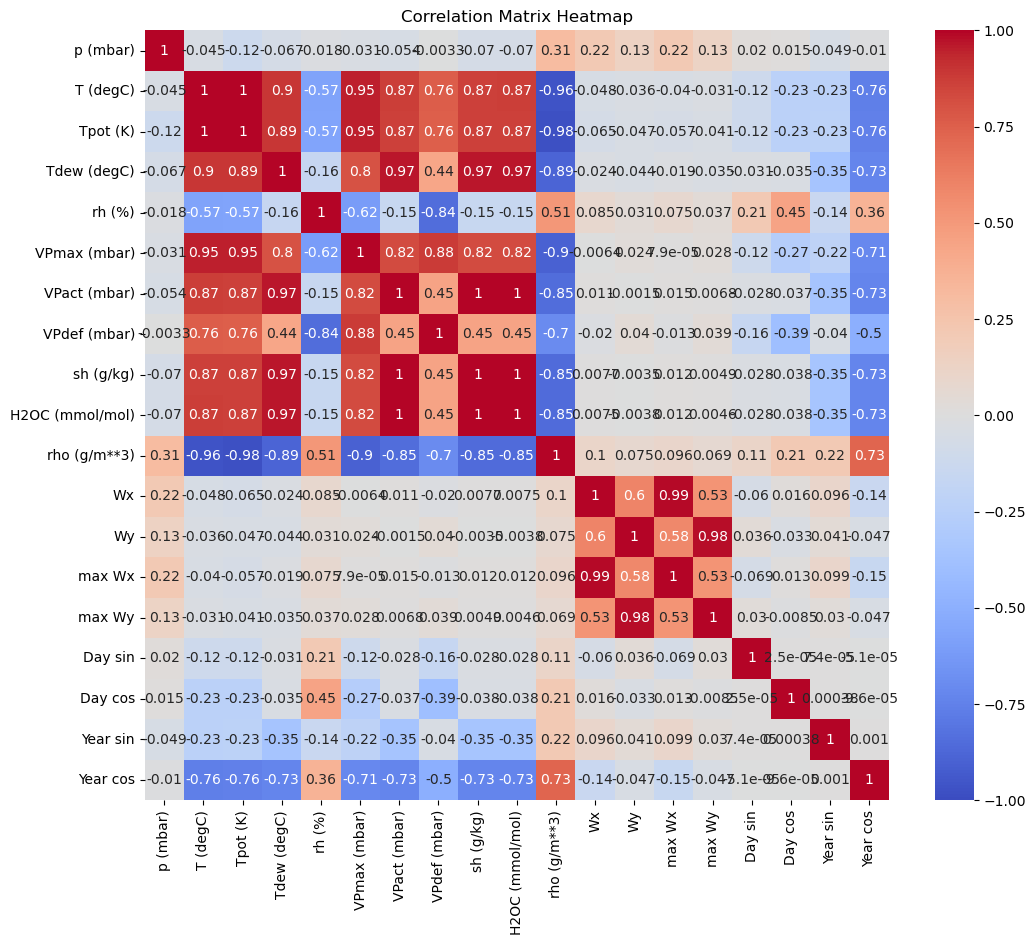

In [105]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [108]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display VIF results
print(vif_data)

           Variable           VIF
0          p (mbar)  1.396727e+07
1          T (degC)  3.007925e+04
2          Tpot (K)  6.964037e+04
3       Tdew (degC)  6.624907e+02
4            rh (%)  1.273989e+03
5      VPmax (mbar)  9.734426e+06
6      VPact (mbar)  4.387116e+06
7      VPdef (mbar)  1.608822e+06
8         sh (g/kg)  3.076034e+06
9   H2OC (mmol/mol)  3.533661e+06
10     rho (g/m**3)  1.232181e+07
11               Wx  6.307514e+01
12               Wy  4.870295e+01
13           max Wx  5.788437e+01
14           max Wy  4.395151e+01
15          Day sin  1.135063e+00
16          Day cos  1.422425e+00
17         Year sin  1.474659e+00
18         Year cos  3.760698e+00


The correlation matrix and VIF values suggest that there is significant multicollinearity in the dataset. 
The extremely high VIF values for many variables indicate that these variables are highly correlated with each other, which can cause issues in regression models by inflating the variances of the coefficient estimates.

#### Correlation Analysis
The heatmap you provided shows the correlation matrix of the variables in your dataset. Here are some key observations:

- High Positive Correlations:

T (degC) and Tpot (K) have a very high correlation (0.99).
Tdew (degC) and rh (%) have a high correlation (0.97).
VPmax (mbar), VPact (mbar), VPdef (mbar), sh (g/kg), and H2OC (mmol/mol) show strong correlations with each other and with T (degC), Tpot (K), Tdew (degC).
rho (g/m**3) shows a strong negative correlation with T (degC), Tpot (K), Tdew (degC).

- High Negative Correlations:

rho (g/m**3) has strong negative correlations with T (degC) (-0.96), Tpot (K) (-0.96), and Tdew (degC) (-0.98).

- Other Observations:

Variables like Wx, Wy, max Wx, and max Wy have moderate to low correlations with most other variables.
The Day and Year sine and cosine components show very low correlations with other variables, indicating they might not contribute much to multicollinearity.
Multicollinearity Analysis
The Variance Inflation Factor (VIF) values you provided are extremely high for several variables, indicating severe multicollinearity issues. Here is the breakdown:

#### VIF Values:

- Extremely High VIF Values:
  
p (mbar): 1.4e+07
VPmax (mbar): 9.7e+06
VPact (mbar): 4.4e+06
VPdef (mbar): 1.6e+06
sh (g/kg): 3.1e+06
H2OC (mmol/mol): 3.5e+06
rho (g/m**3): 1.2e+07
Very High VIF Values:

T (degC): 3.0e+04
Tpot (K): 6.9e+04
rh (%): 1.3e+03
Tdew (degC): 662.49

- Moderate to Low VIF Values:

Wx, Wy, max Wx, max Wy have VIF values ranging from 43.95 to 63.08, which are still high but relatively lower than the other variables.
Day sin, Day cos, Year sin, Year cos have VIF values close to 1, indicating no multicollinearity issues.

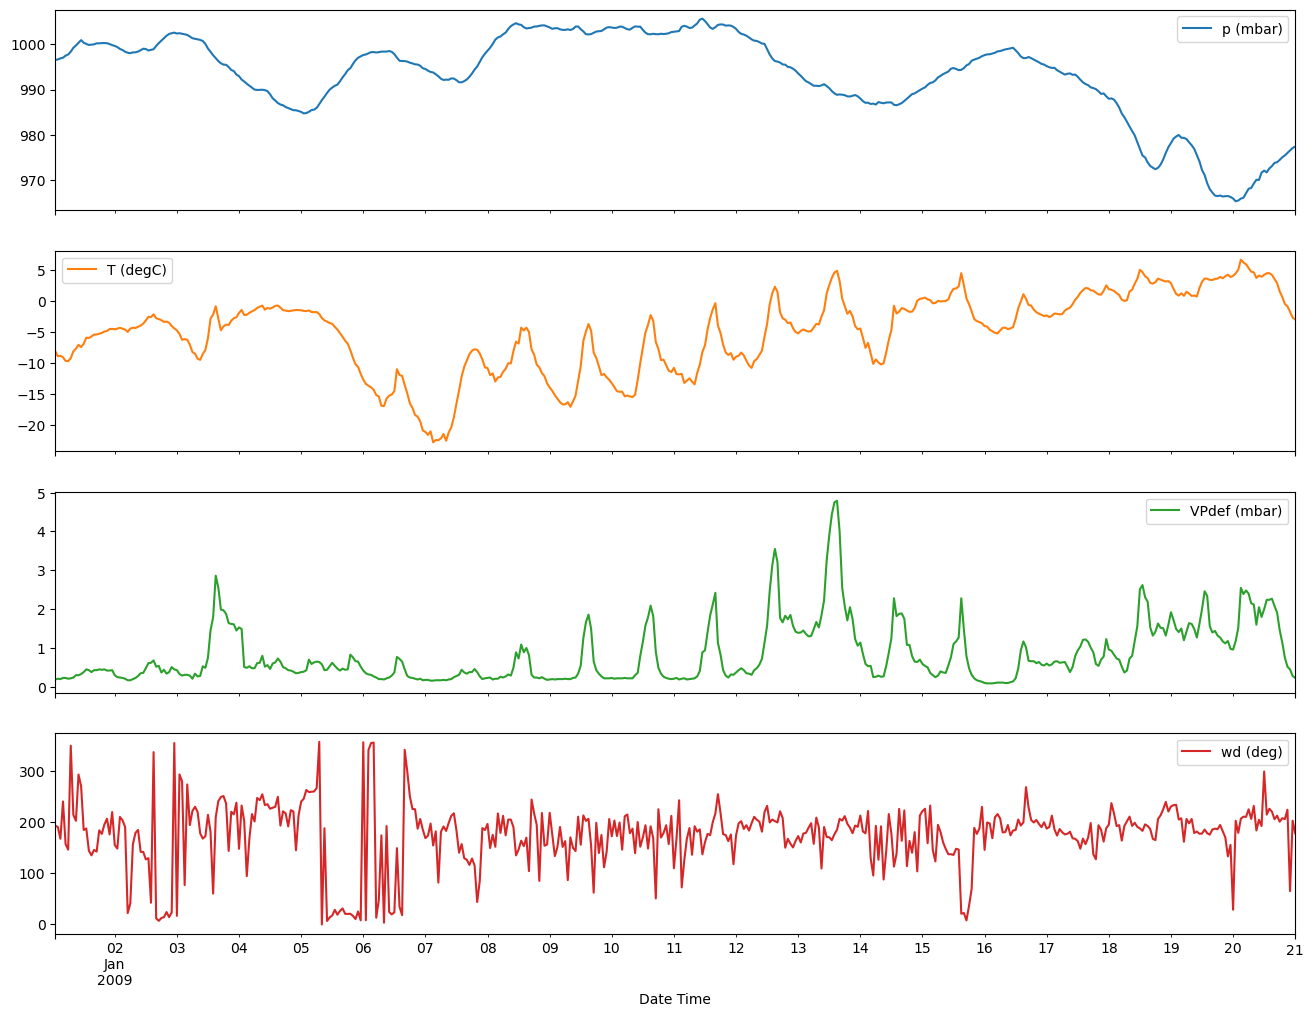

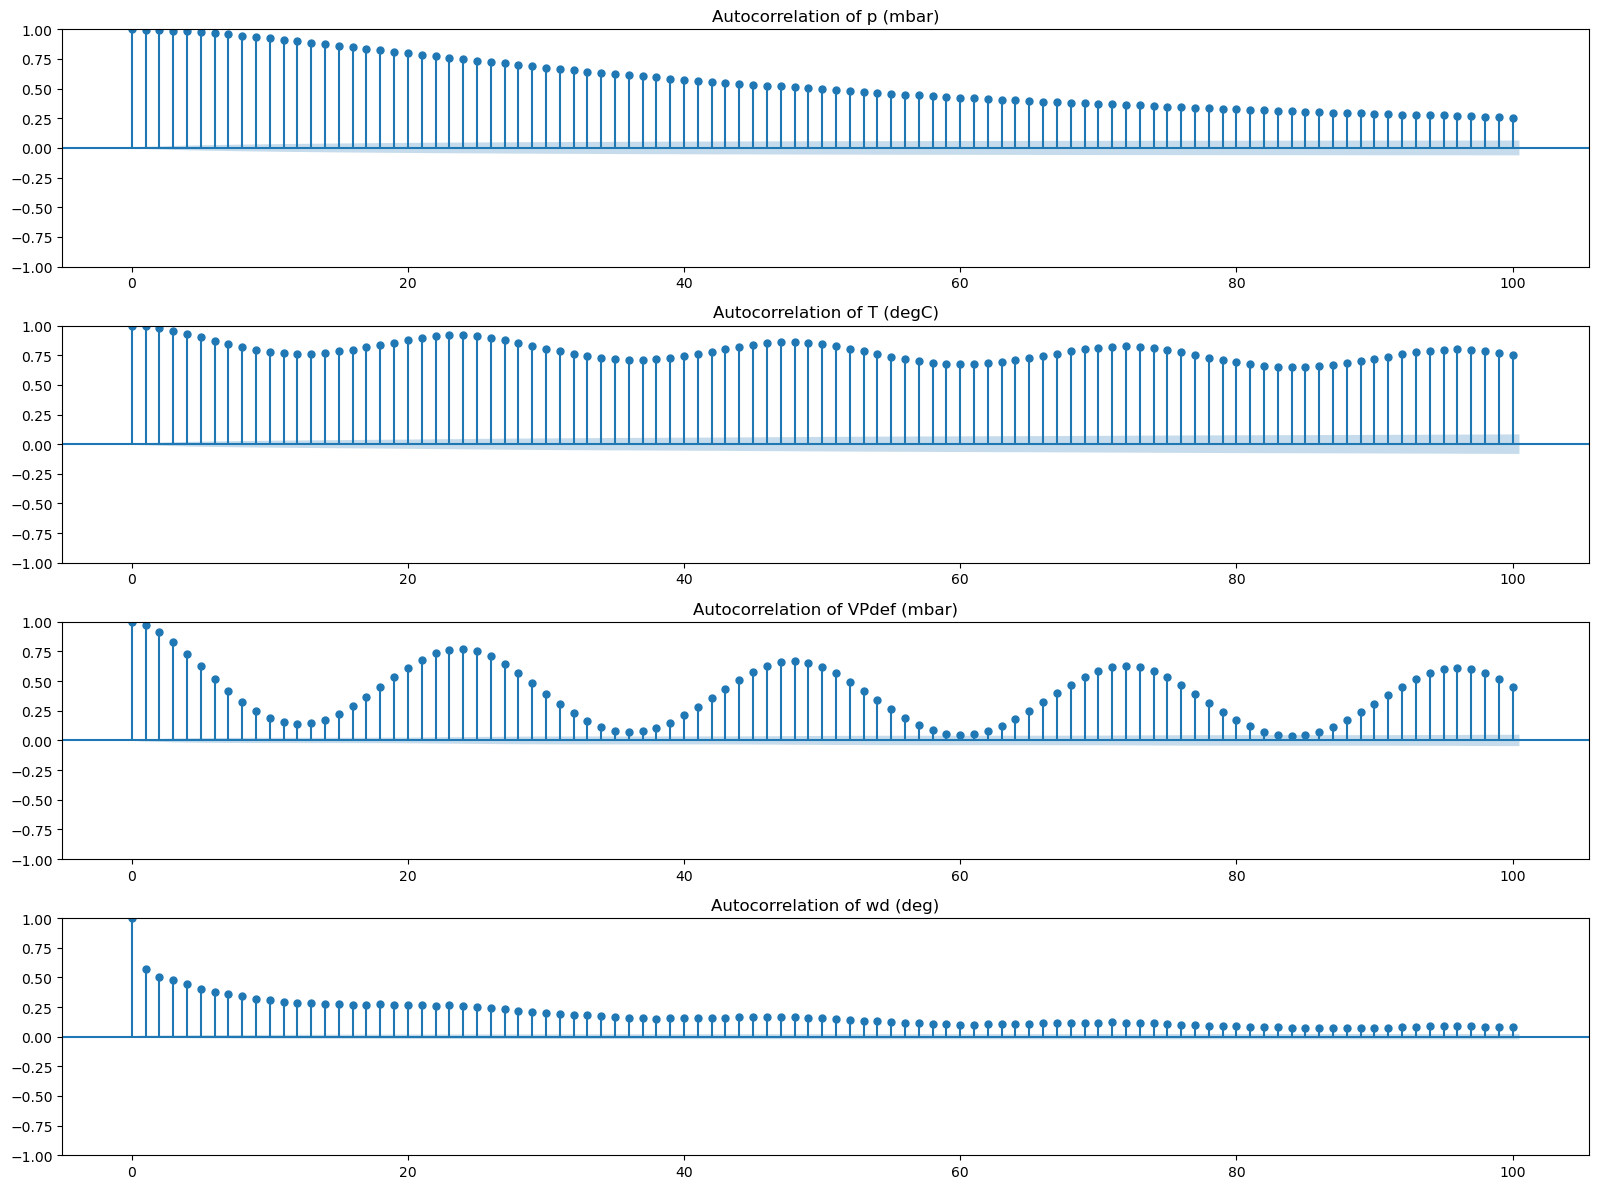

In [12]:
#Select the candidates to be the variable to predict (y) that does not have to contain seasonality
#To observe the seasonality we are going to plot the last values ​​of the selected series and the autocorrelations for each selected series
plot_cols = ['p (mbar)','T (degC)', 'VPdef (mbar)', 'wd (deg)']
plot_features = df[plot_cols][:480]

plot_features.index = pd.to_datetime(plot_features.index)

_ = plot_features.plot(subplots=True, figsize=(16, 12))
plt.show()

# Plot Autocorrelation Function (ACF) for each candidate variable
fig, axes = plt.subplots(len(plot_cols), 1, figsize=(16, 12))
for i, var in enumerate(plot_cols):
    plot_acf(df[var].dropna(), ax=axes[i], lags=100)
    axes[i].set_title(f'Autocorrelation of {var}')

plt.tight_layout()
plt.show()

### Analysis of Candidate Variables:

To select the appropriate target variable (y) for prediction from your multivariate time series dataset, we need to ensure that the chosen variable does not exhibit strong seasonality. Based on the provided information, analysis, and plots, here's a detailed evaluation of the potential target variables:

#### p (mbar) (Pressure):

Description: The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
ACF Plot: The autocorrelation function (ACF) plot shows a gradual decline in correlation without significant peaks, indicating a lack of strong seasonality.
Time Series Plot: The plot does not show obvious repeated patterns over the years, suggesting the absence of clear seasonality.

#### T (degC) (Temperature):

Description: Temperature in Celsius.
ACF Plot: The ACF plot shows significant peaks at regular intervals, indicating strong seasonality.
Time Series Plot: The plot clearly shows repeated patterns corresponding to seasonal changes (e.g., annual cycles), confirming the presence of strong seasonality.

#### VPdef (mbar) (Vapor Pressure Deficit):

Description: Vapor pressure deficit.
ACF Plot: The ACF plot shows sinusoidal patterns, indicating strong seasonality.
Time Series Plot: The plot shows repeated peaks, further confirming the presence of strong seasonality.

#### wd (deg) (Wind Direction):

Description: Wind direction in degrees.
ACF Plot: The ACF plot shows a gradual decline without significant peaks, indicating a lack of strong seasonality.
Time Series Plot: The plot does not show obvious repeated patterns, suggesting the absence of clear seasonality.

### Conclusion:
Based on the analysis, both p (mbar) (Pressure) and wd (deg) (Wind Direction) are suitable candidates for the target variable (y) as they do not exhibit strong seasonality.


### Detailed Rationale for Choosing p (mbar) (Pressure):

No Strong Seasonality: The ACF plot and time series plot for p (mbar) indicate no significant seasonal patterns, making it a suitable candidate for time series prediction without seasonal bias.
Importance in Meteorology: Atmospheric pressure is a crucial parameter in meteorological studies. Accurate prediction of pressure can be valuable for weather forecasting and understanding atmospheric dynamics.
Stability: The pressure data appears to have a smoother and more stable pattern compared to other variables like wind direction, which can be more erratic and less predictable.
Given these points, it is appropriate to choose p (mbar) as the target variable for your prediction task.

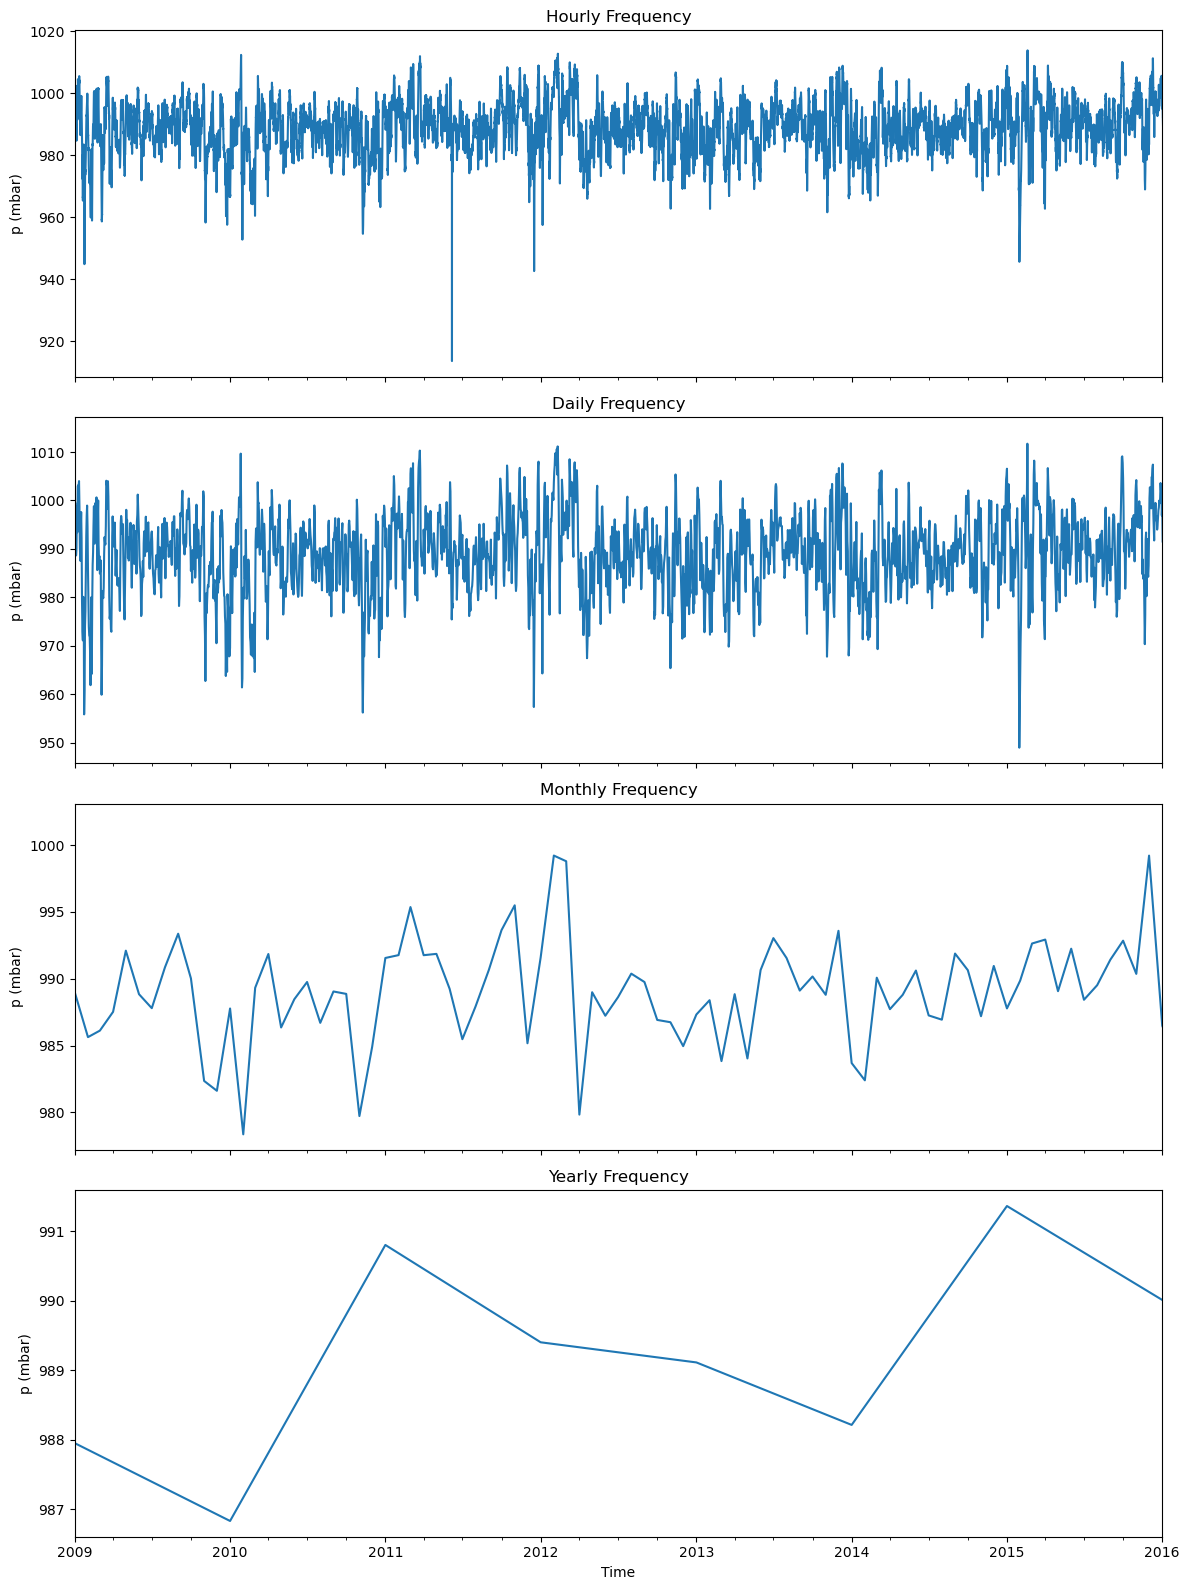

In [109]:
# Plotting the series at different frequencies (H/D/M/Y)
#Plot the chosen series p (mbar) at different time frequencies to see if there is seasonality

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

df['p (mbar)'].plot(ax=axes[0], title='Hourly Frequency')
axes[0].set_ylabel('p (mbar)')

df['p (mbar)'].resample('D').mean().plot(ax=axes[1], title='Daily Frequency')
axes[1].set_ylabel('p (mbar)')

df['p (mbar)'].resample('M').mean().plot(ax=axes[2], title='Monthly Frequency')
axes[2].set_ylabel('p (mbar)')

df['p (mbar)'].resample('Y').mean().plot(ax=axes[3], title='Yearly Frequency')
axes[3].set_ylabel('p (mbar)')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

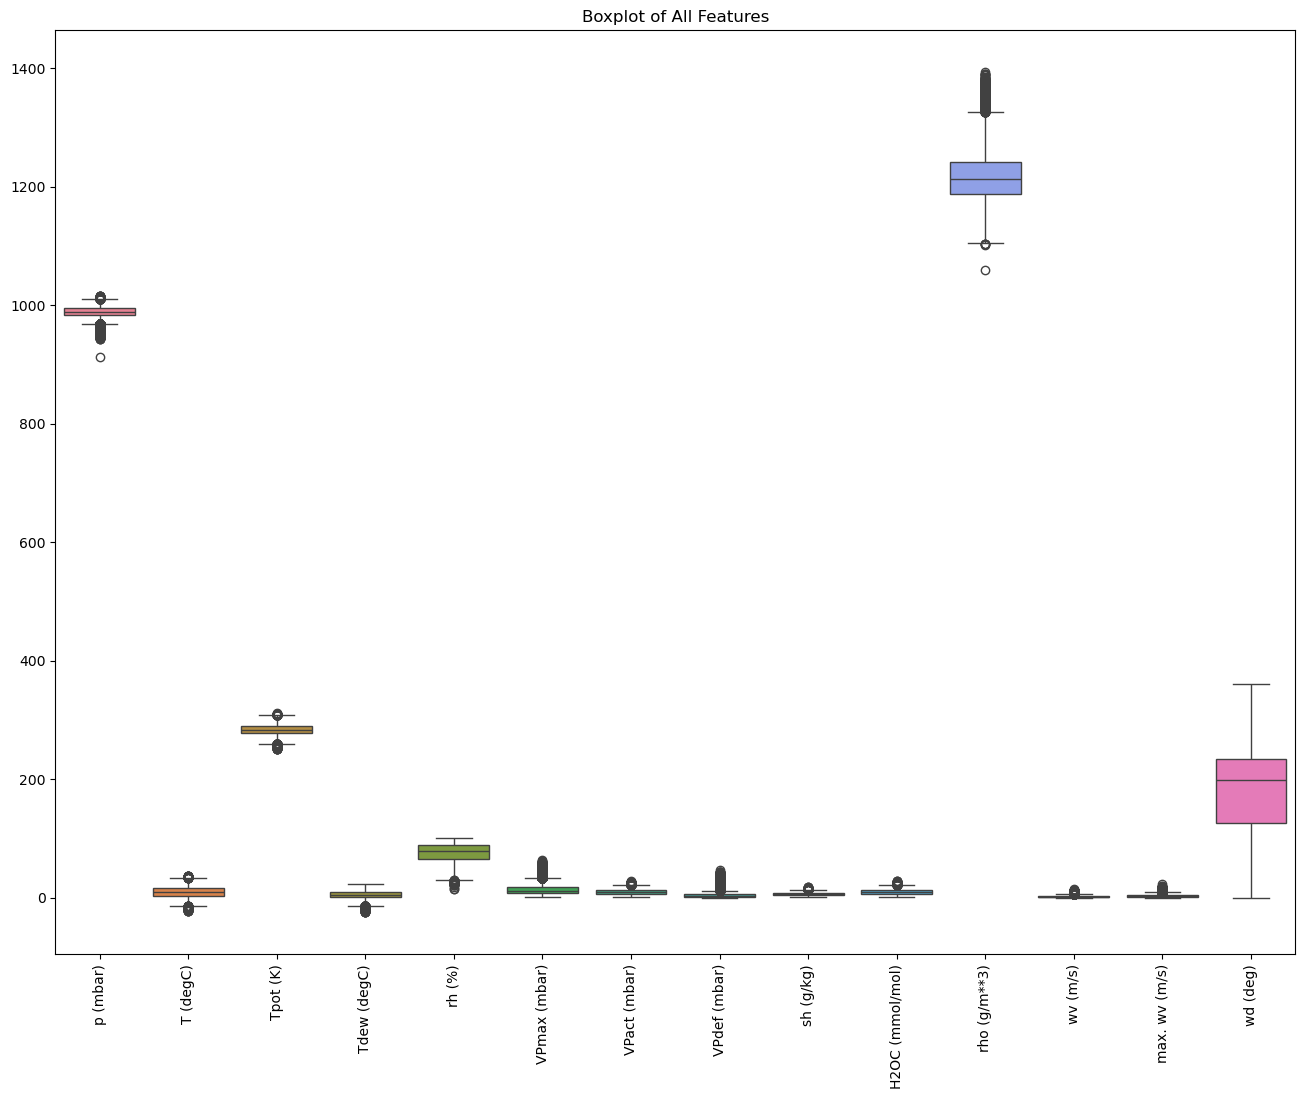

In [14]:
#The distribution of the features of the dataset and the values ​​identified as outliers are observed with bloxplots, histograms and histograms2d
#Create boxplots for all features
plt.figure(figsize=(16, 12))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Boxplot of All Features')
plt.show()

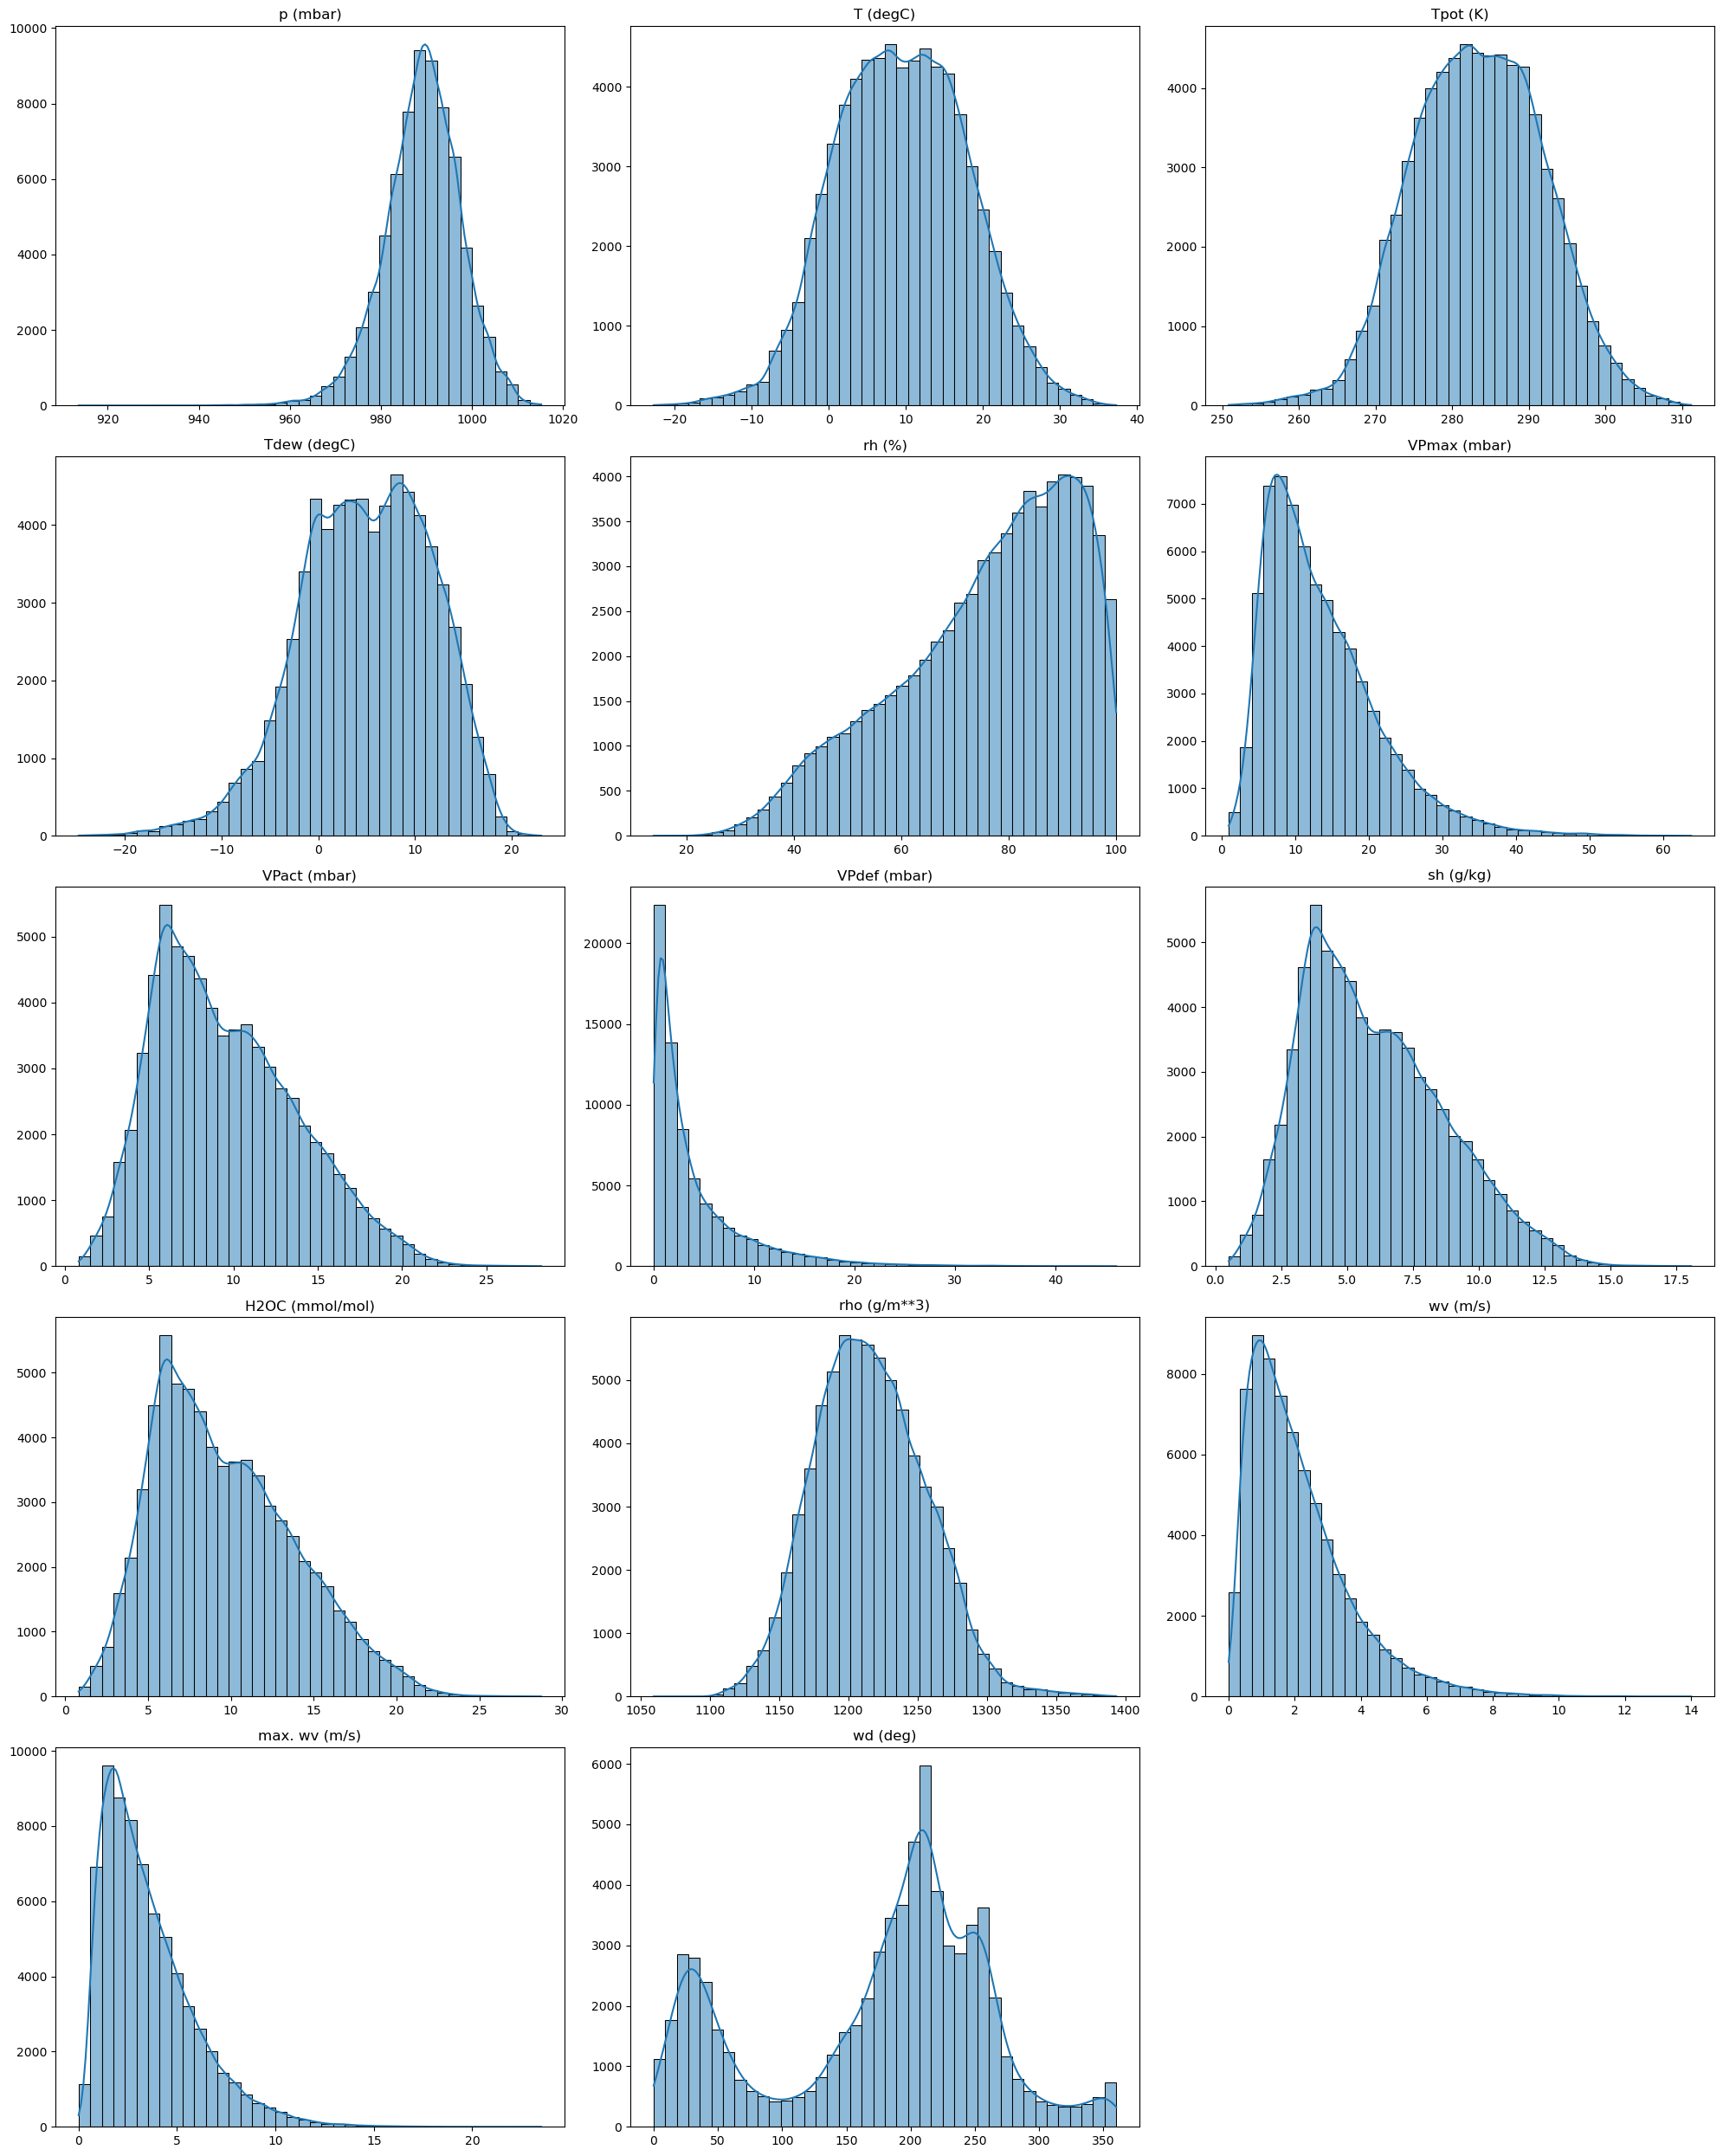

In [15]:
#We are going to analyze the distribution of the data of each feature
#Create histograms for all features
features_to_plot = df.columns
num_cols = 3
num_rows = -(-len(features_to_plot) // num_cols)

plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(features_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[column], bins=40, kde=True)
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

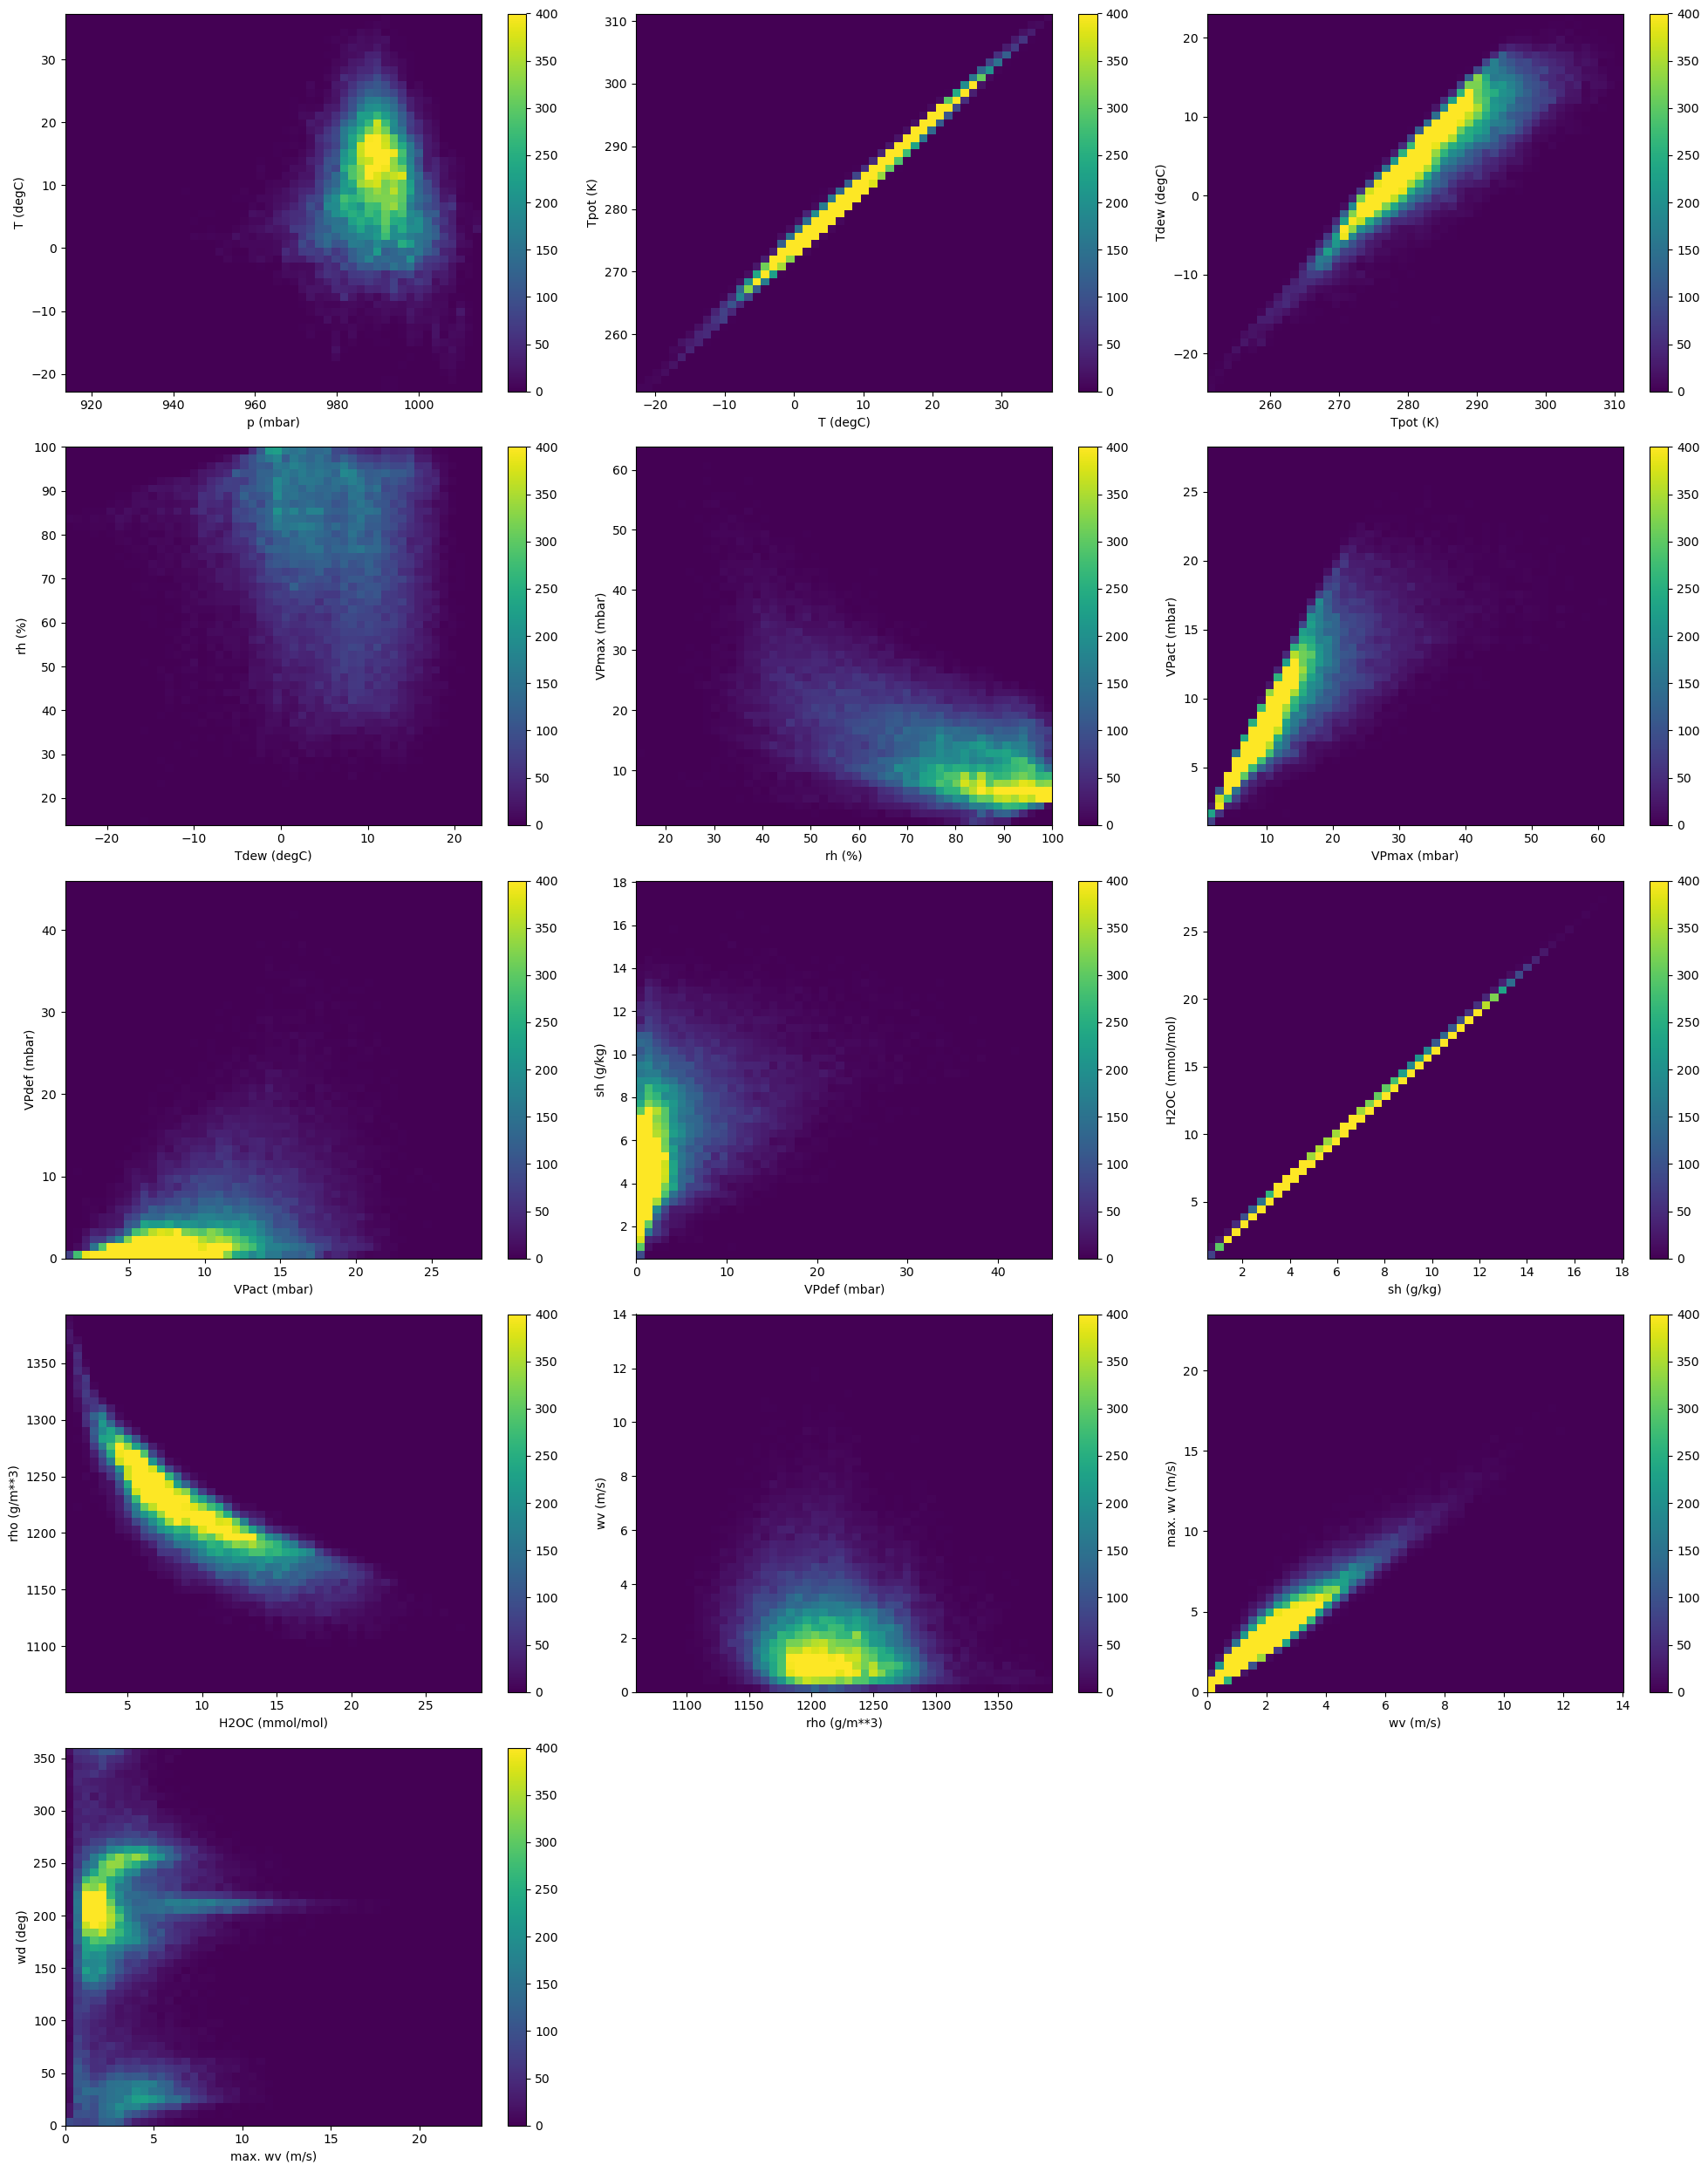

In [16]:
#Create 2D histograms for all pairs of features
num_features = len(features_to_plot)
num_cols = 3
num_rows = -(-num_features // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

for i, (col1, col2) in enumerate(zip(features_to_plot[:-1], features_to_plot[1:])):
    ax = axes.flat[i]
    hist = ax.hist2d(df[col1], df[col2], bins=(50, 50), vmax=400)
    fig.colorbar(hist[3], ax=ax)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.axis('tight')

for ax in axes.flat[i+1:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [17]:
def calculate_wind_components(wind_speed, wind_direction):
    """
    Calculate the wind components (Wx, Wy) given wind speed (wv) and direction (wd) in degrees.
    
    The function waits for the input of the features wind speed (wv) and wind direction (wd). 
    Returns two numpy arrays (Wx, Wy) where sin/cos has been applied respectively after performing the transformations.
    """
    wind_rad = np.deg2rad(wind_direction)
    Wx = wind_speed * np.cos(wind_rad)
    Wy = wind_speed * np.sin(wind_rad)
    return Wx, Wy

def calculate_time_components(timestamp_series):
    """
    Calculate the sinus and cosinus components for day and year given a timestamp series.

    Function expects timestamp series from dataset to apply sin/cos transformations.
    """
    day = 24 * 60 * 60
    year = (365.2425) * day
    timestamp_s = timestamp_series.map(datetime.datetime.timestamp)
    
    day_sin = np.sin(timestamp_s * (2 * np.pi / day))
    day_cos = np.cos(timestamp_s * (2 * np.pi / day))
    year_sin = np.sin(timestamp_s * (2 * np.pi / year))
    year_cos = np.cos(timestamp_s * (2 * np.pi / year))
    
    return day_sin, day_cos, year_sin, year_cos

#Apply the wind component functions
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd = df.pop('wd (deg)')

df['Wx'], df['Wy'] = calculate_wind_components(wv, wd)
df['max Wx'], df['max Wy'] = calculate_wind_components(max_wv, wd)

#Apply the time component function
df['Day sin'], df['Day cos'], df['Year sin'], df['Year cos'] = calculate_time_components(df.index.to_series())


In [19]:
# Split the data (70/20/10)
n = len(df)
train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

#Separate features and target variables for prediction
y_train = train_df.pop('p (mbar)')
y_val = val_df.pop('p (mbar)')
y_test = test_df.pop('p (mbar)')
X_train, X_val, X_test = train_df, val_df, test_df

#Apply StandardScaler to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


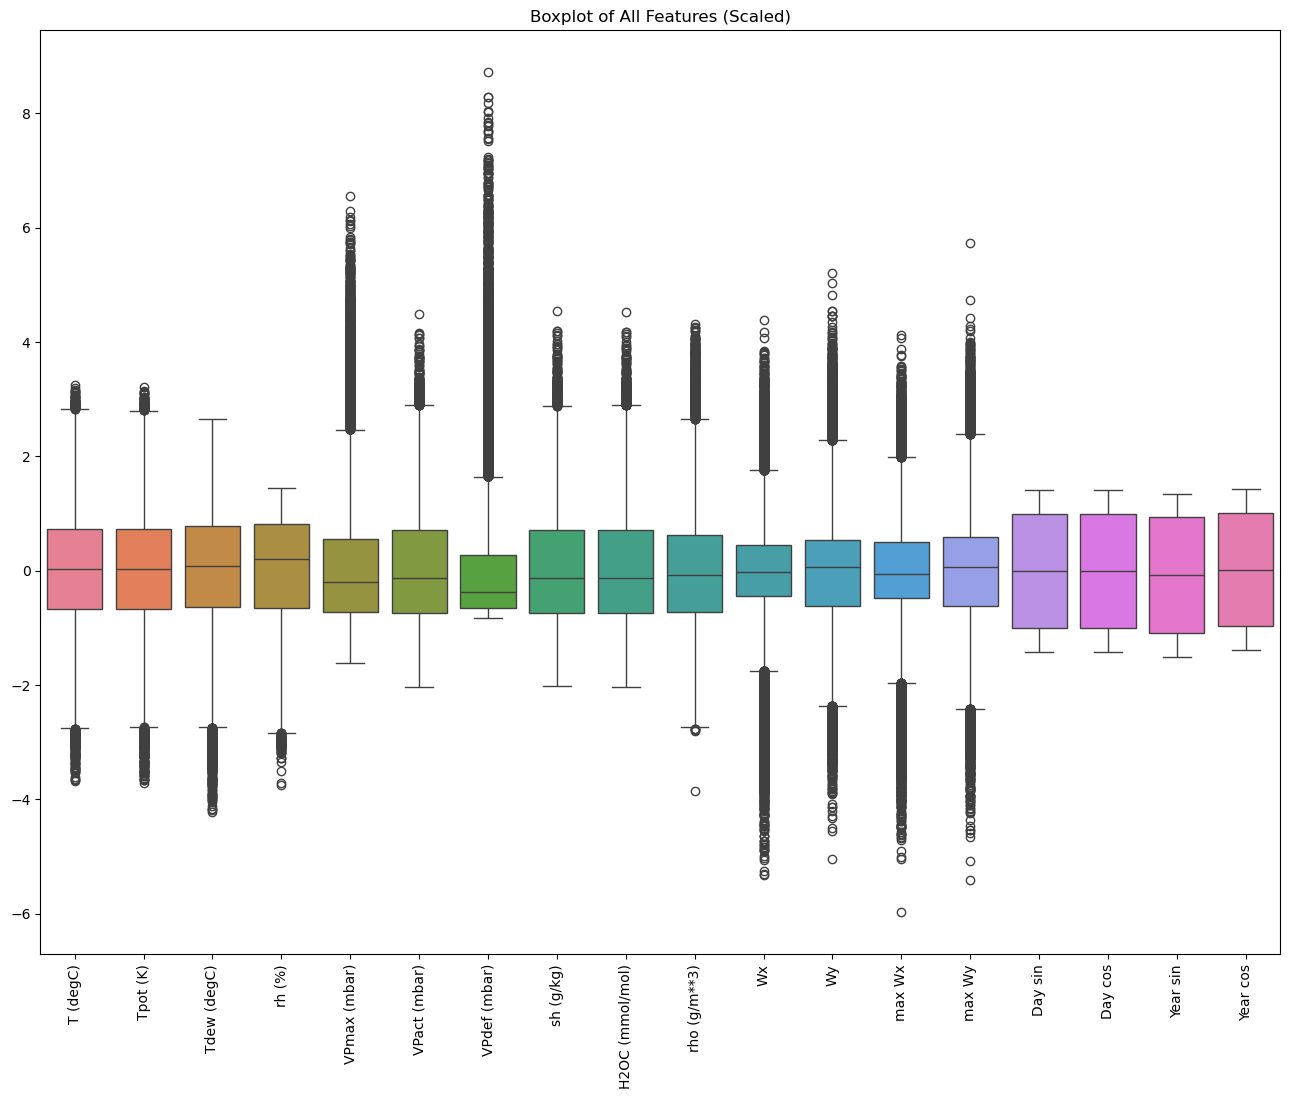

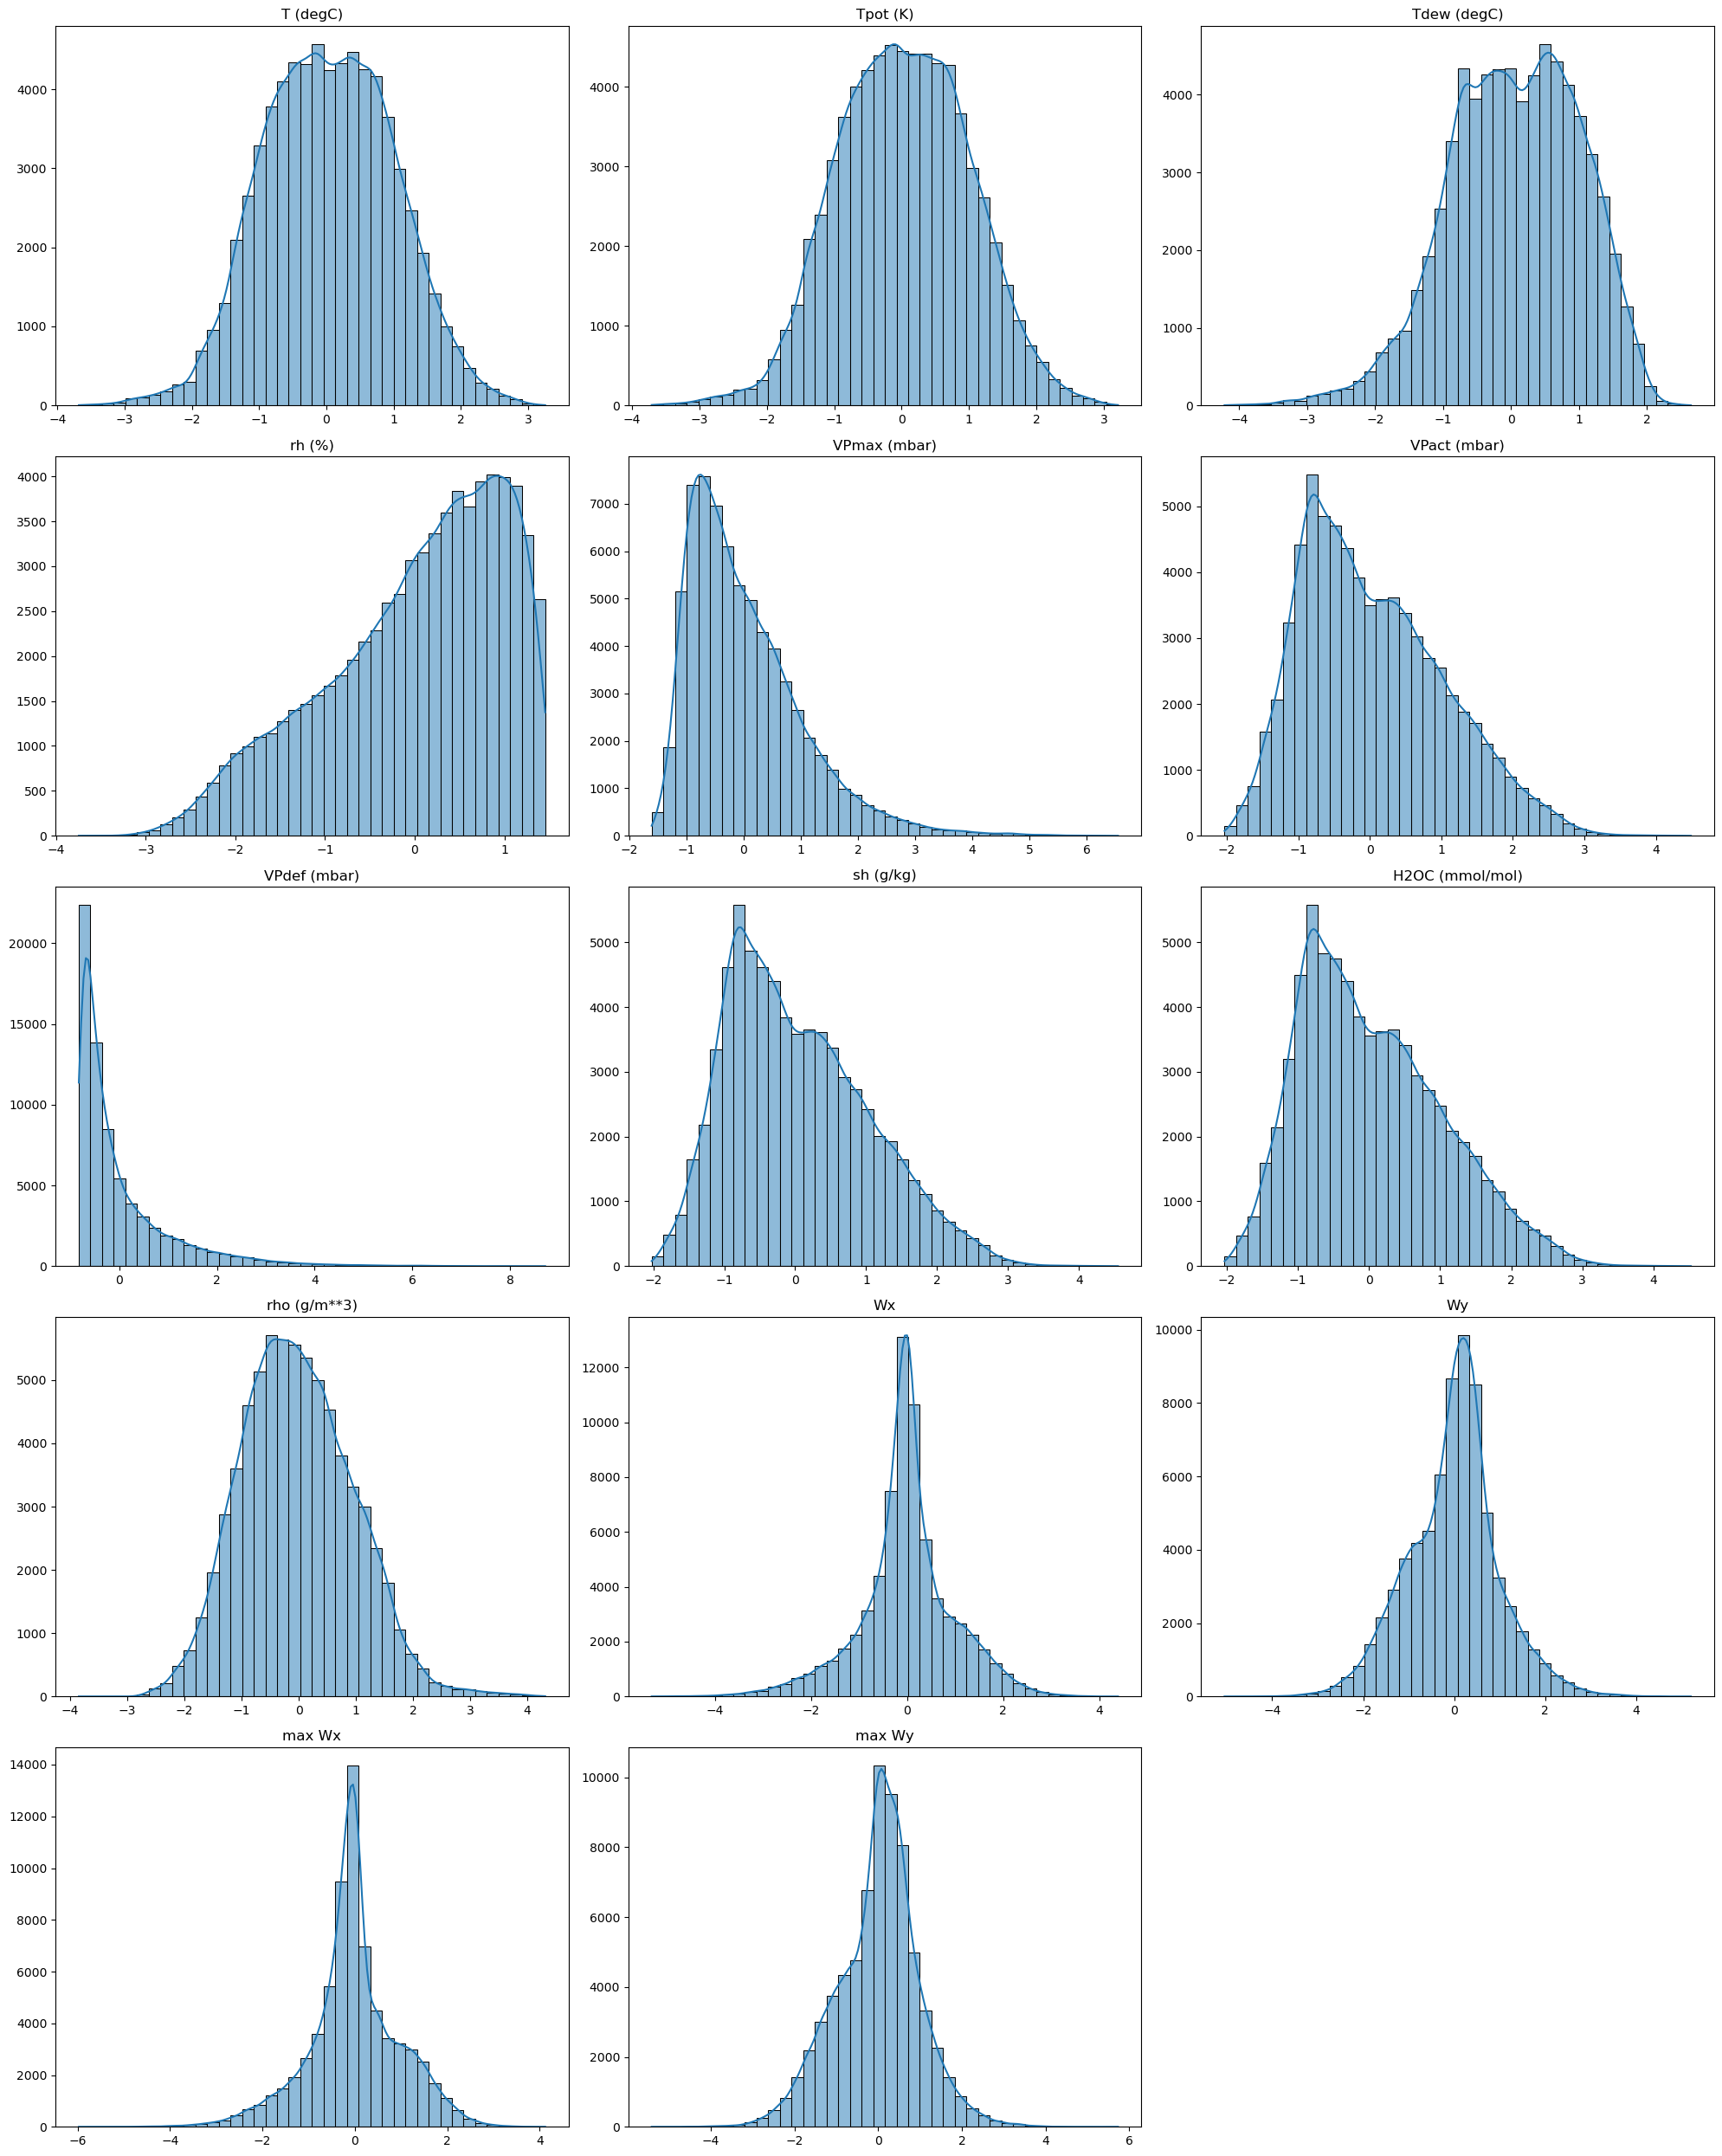

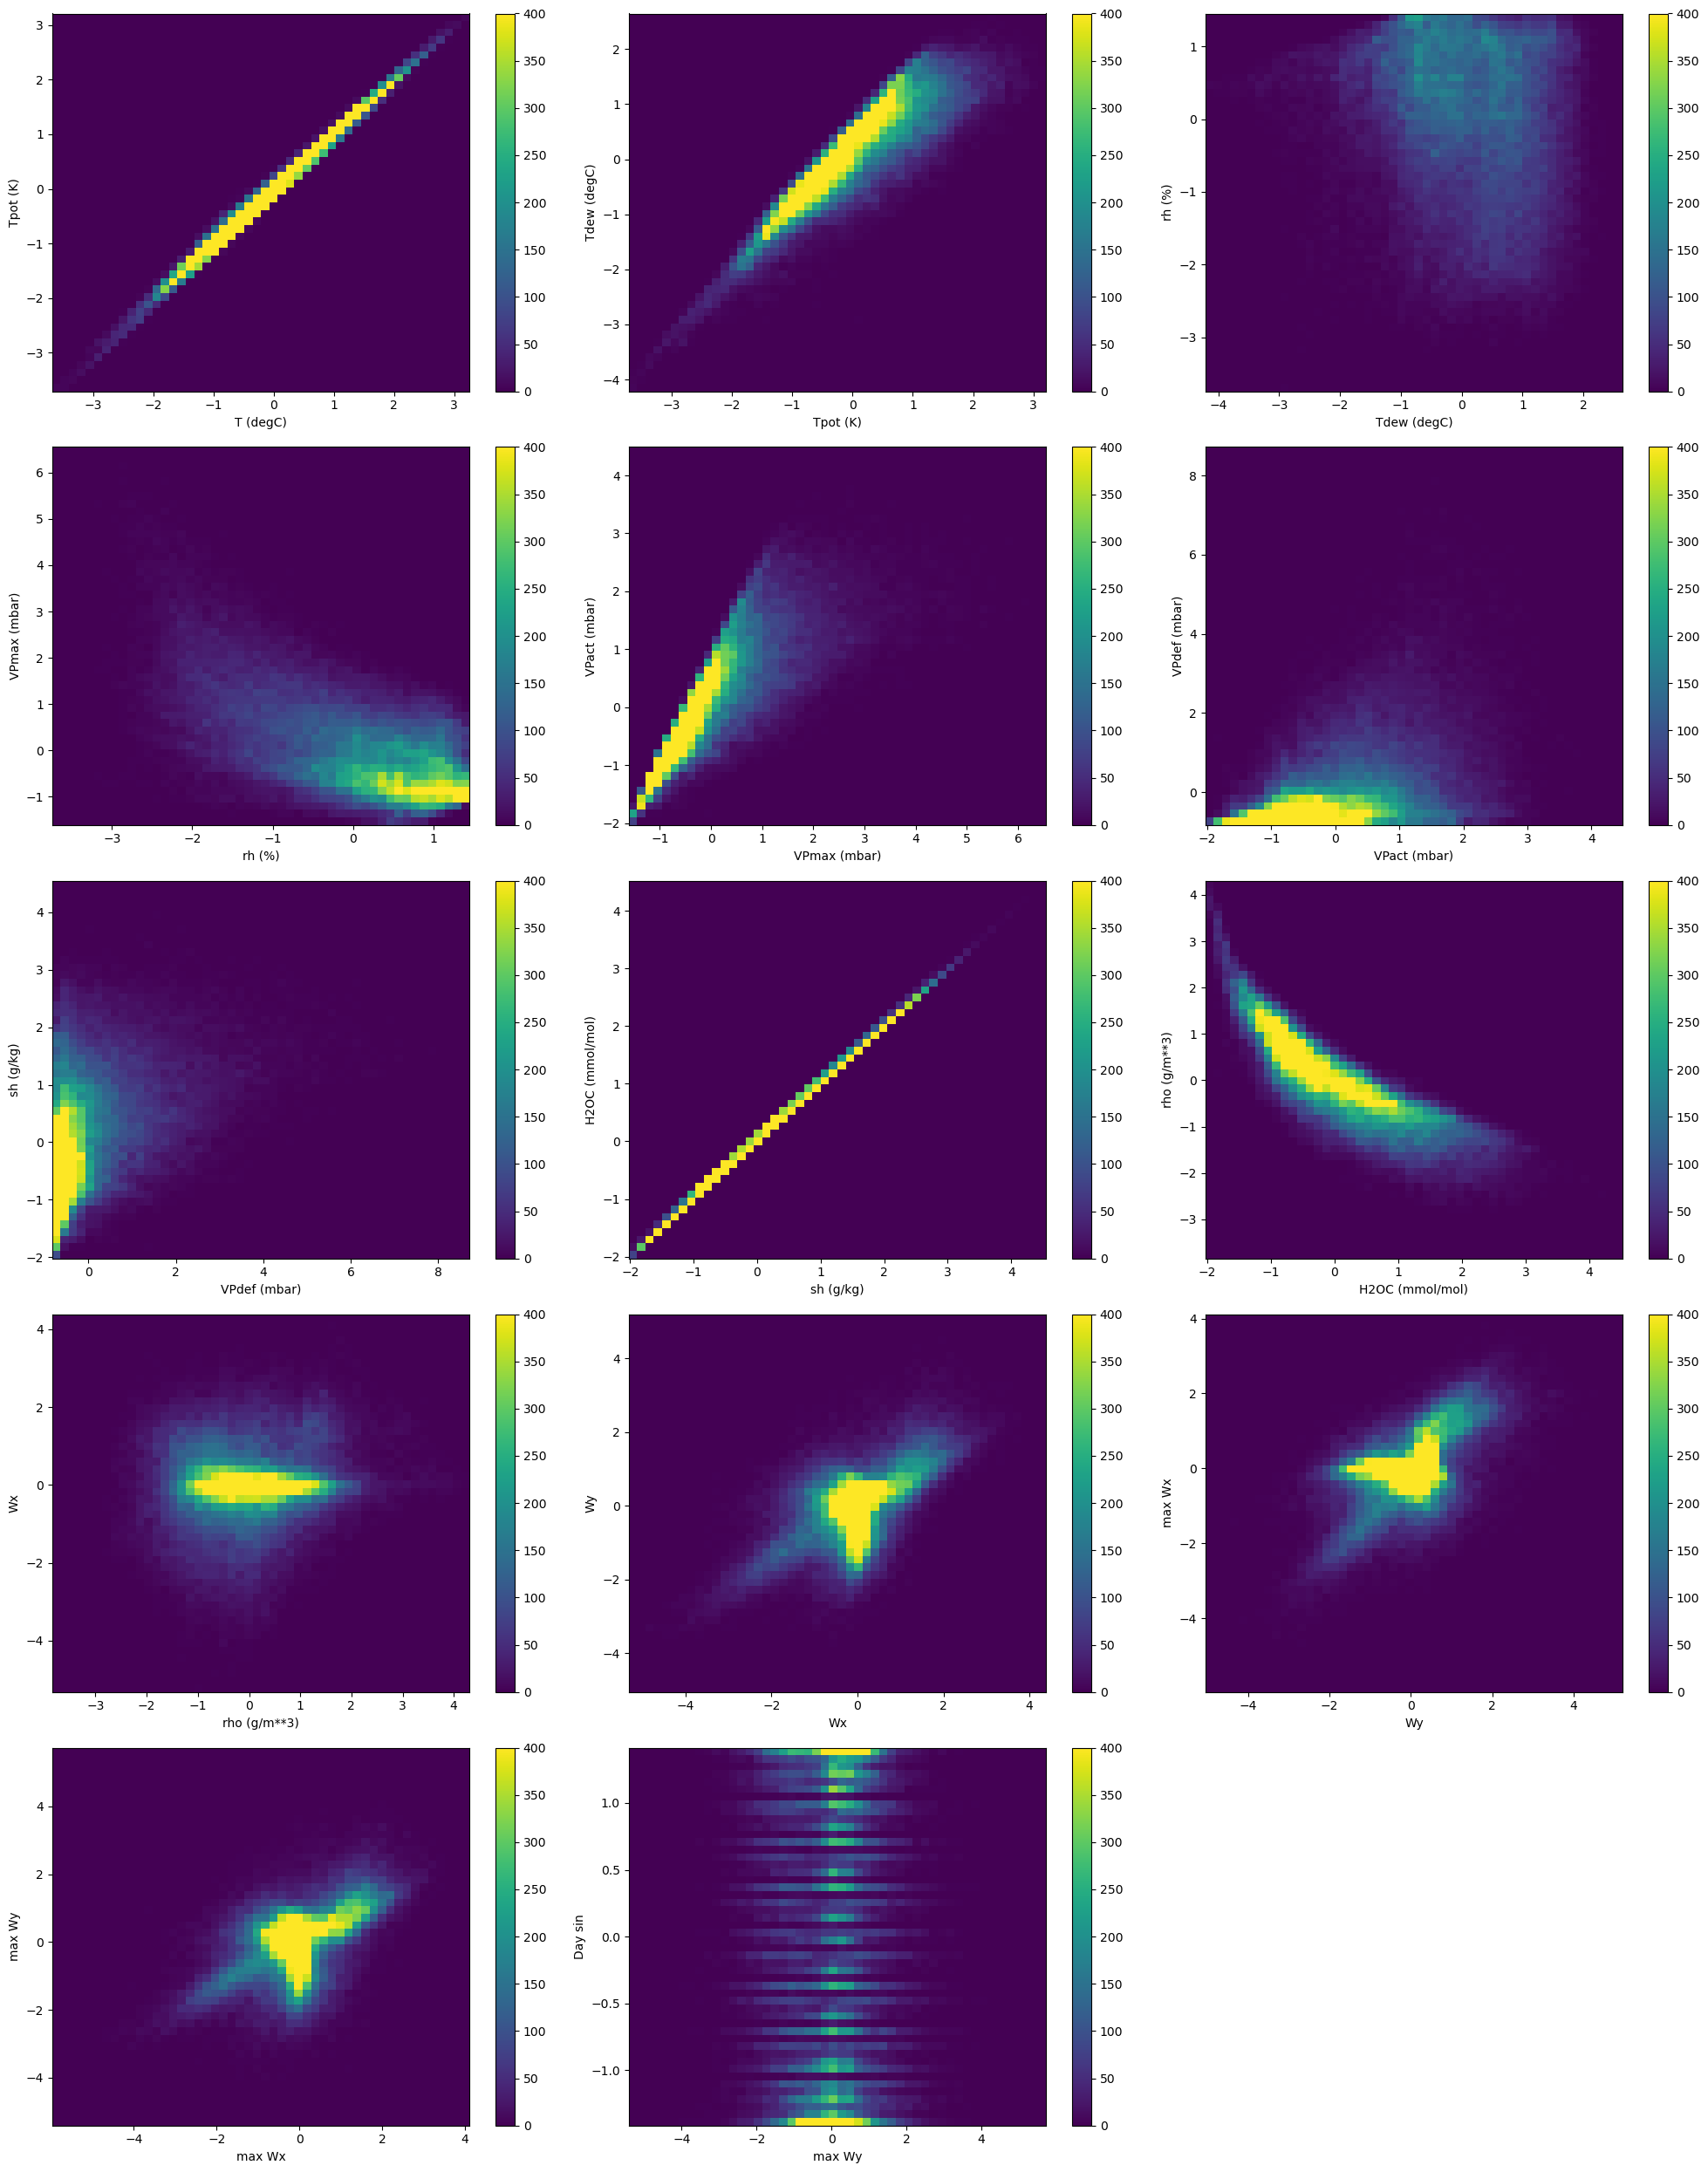

In [20]:
#Check whether the transformations and standardizations have been carried out correctly using the previous plots (boxplot, histograms, 2d histograms)

#Convert the scaled numpy arrays back to DataFrame for plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

df_scaled = pd.concat([X_train_scaled_df, X_val_scaled_df, X_test_scaled_df])

#Plot the boxplot for all features
plt.figure(figsize=(16, 12))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=90)
plt.title('Boxplot of All Features (Scaled)')
plt.show()

#Plot histograms for all features
features_to_plot = df_scaled.columns[:-4]
num_cols = 3
num_rows = -(-len(features_to_plot) // num_cols)  # Ceiling division

plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(features_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df_scaled[column], bins=40, kde=True)
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

#Create 2D histograms for all pairs of features
features_to_plot = df_scaled.columns[:-3]
num_features = len(features_to_plot)
num_cols = 3
num_rows = -(-num_features // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

for i, (col1, col2) in enumerate(zip(features_to_plot[:-1], features_to_plot[1:])):
    ax = axes.flat[i]
    hist = ax.hist2d(df_scaled[col1], df_scaled[col2], bins=(50, 50), vmax=400)
    fig.colorbar(hist[3], ax=ax)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.axis('tight')

for ax in axes.flat[i+1:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

### Evaluation metrics:

The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) metrics will be selected for the evaluation of the models.

#### Mean Absolute Error (MAE):

- Interpretation:

MAE represents the average absolute difference between the predicted values and the actual values. It is a straightforward metric that provides a clear indication of the average magnitude of errors in a set of predictions, without considering their direction (positive or negative).
Because it measures the average absolute error, MAE is easy to interpret and understand. If the MAE is 5, it means that, on average, the model’s predictions are off by 5 units from the actual values.

- Robustness to Outliers:

MAE is more robust to outliers compared to RMSE because it does not square the errors. This means that each error contributes proportionally to the overall metric, preventing a few large errors from disproportionately influencing the MAE.

#### Root Mean Squared Error (RMSE):

- Interpretation:

RMSE measures the square root of the average squared differences between predicted and actual values. By squaring the errors before averaging, RMSE gives higher weight to larger errors.
This squaring effect means that RMSE is particularly useful when large errors are especially undesirable. If the RMSE is 7, it indicates that the typical error magnitude is around 7 units, with larger errors being penalized more heavily.

- Sensitivity to Outliers:

Unlike MAE, RMSE is sensitive to outliers due to the squaring of errors. Large errors have a greater impact on RMSE, making it a good metric for highlighting models that have a few large but critical errors.

In [22]:
#Selected TimeSeriesSplit is used to perform cross-validation on time series data, preserving the order of observations and avoiding data leakage
#from the future. It ensures that the model is trained and validated on temporally ordered data.

ts_cv = TimeSeriesSplit(n_splits=5, gap=24)

# Define models and hyperparameters
models = {'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': xgb.XGBRegressor()}

params = {'LinearRegression': {'fit_intercept': [True, False], 'positive': [True, False]},
    'RandomForestRegressor': {'n_estimators': [50, 100, 200, 300]},
    'SVR': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']},
    'KNeighborsRegressor': {'n_neighbors': [3, 5, 7, 9]},
    'GradientBoostingRegressor': {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
    'XGBRegressor': {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]}}

print('-' * 80)
for name, model in models.items():
    grid = GridSearchCV(model, params[name], cv=ts_cv, scoring='neg_mean_absolute_error')
    grid.fit(X_train_scaled, y_train)
    with open(f'/Users/nfanlo/dev/technical-test/part2/models/{name}.pkl', 'wb') as f:
        pickle.dump(grid.best_estimator_, f)
    y_pred = grid.best_estimator_.predict(X_test_scaled)
    print(f'{name} - Best Params: {grid.best_params_},\nMAE: {mean_absolute_error(y_test, y_pred)}, RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    print('-' * 80)

--------------------------------------------------------------------------------
LinearRegression - Best Params: {'fit_intercept': True, 'positive': False},
MAE: 0.06676760697059966, RMSE: 0.09005840434653604
--------------------------------------------------------------------------------
RandomForestRegressor - Best Params: {'n_estimators': 200},
MAE: 0.43302692582026175, RMSE: 0.8474776108520444
--------------------------------------------------------------------------------
SVR - Best Params: {'C': 10.0, 'kernel': 'linear'},
MAE: 0.06688763347549066, RMSE: 0.09168799274318384
--------------------------------------------------------------------------------
KNeighborsRegressor - Best Params: {'n_neighbors': 9},
MAE: 4.741409415121256, RMSE: 6.201996702276564
--------------------------------------------------------------------------------
GradientBoostingRegressor - Best Params: {'learning_rate': 0.2, 'n_estimators': 300},
MAE: 0.6679187053812932, RMSE: 0.9653316382122389
-------------

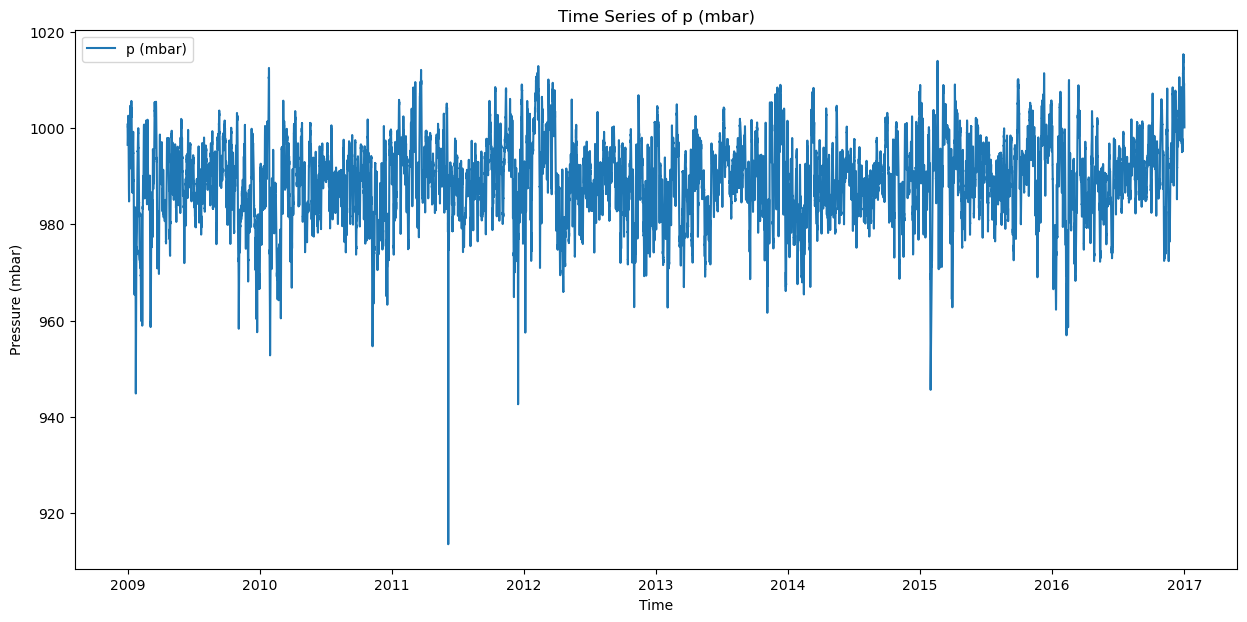

In [23]:
#Plot the time series of 'p (mbar)' from dataframe
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['p (mbar)'], label='p (mbar)')
plt.xlabel('Time')
plt.ylabel('Pressure (mbar)')
plt.title('Time Series of p (mbar)')
plt.legend()
plt.show()

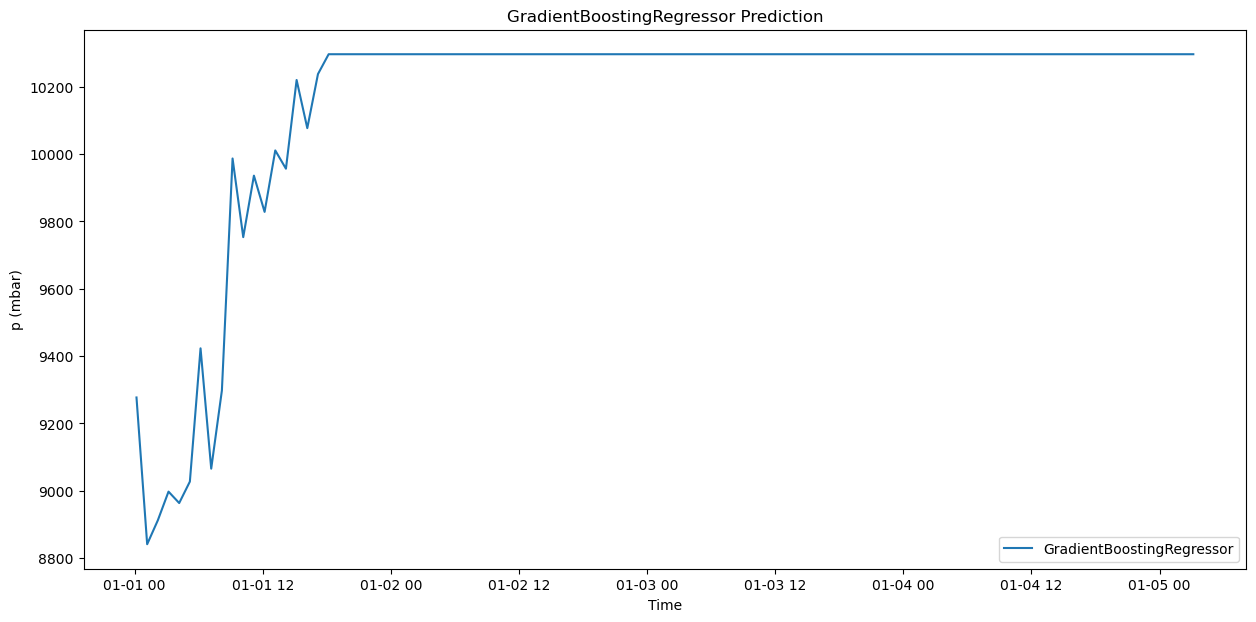

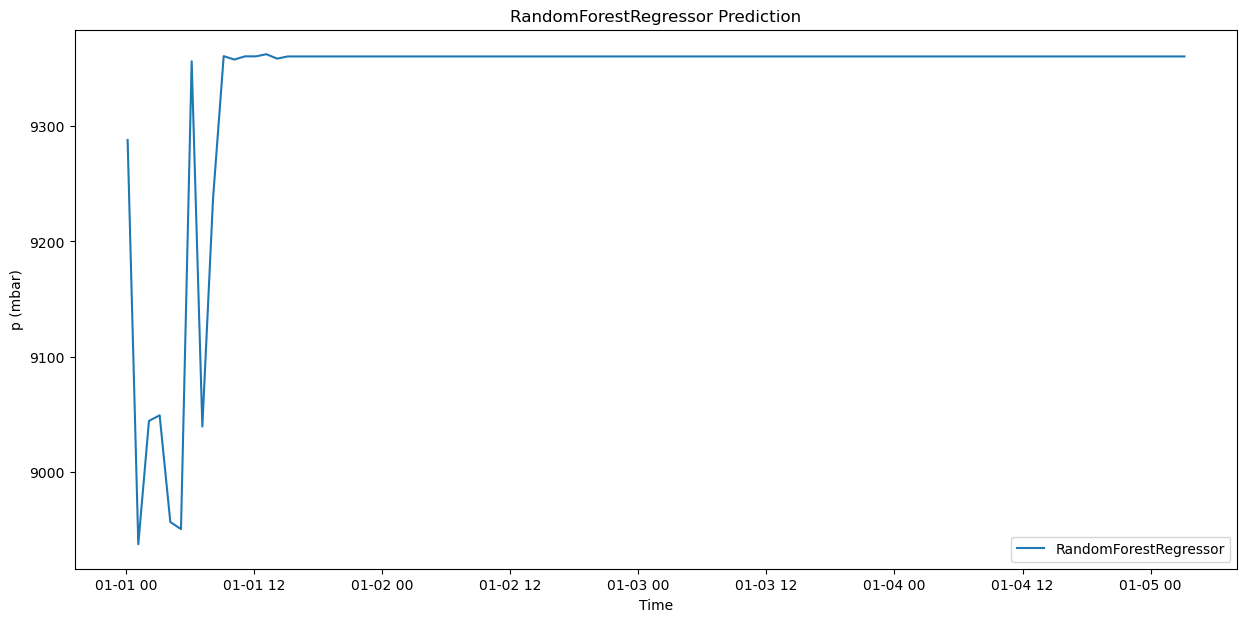

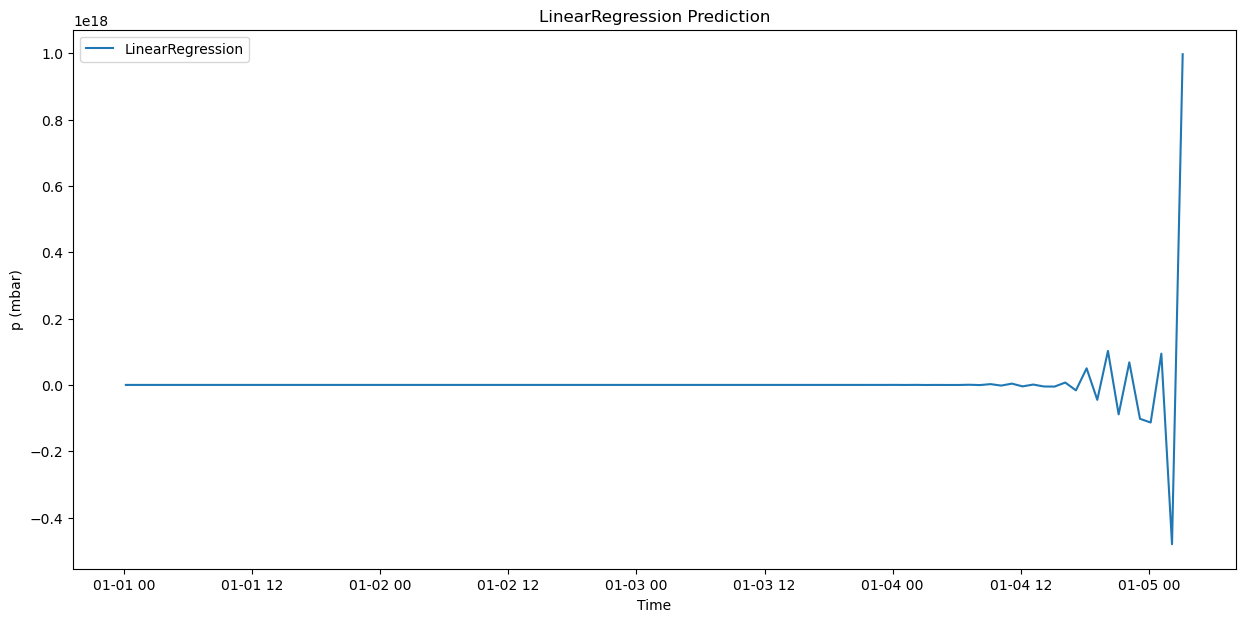

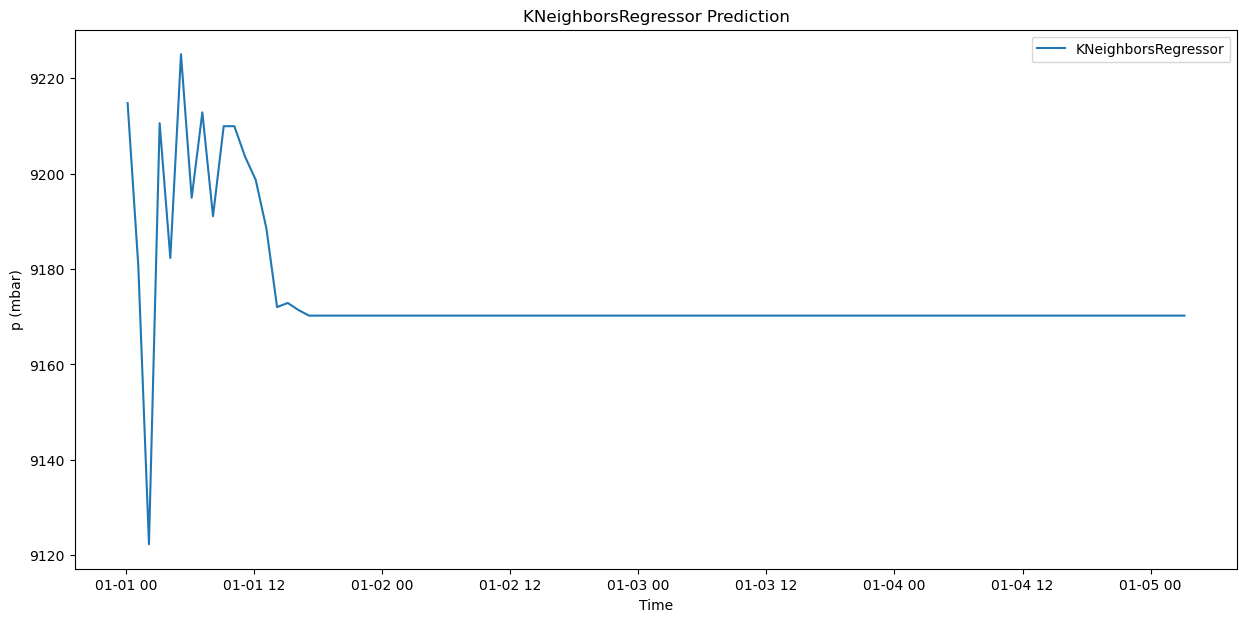

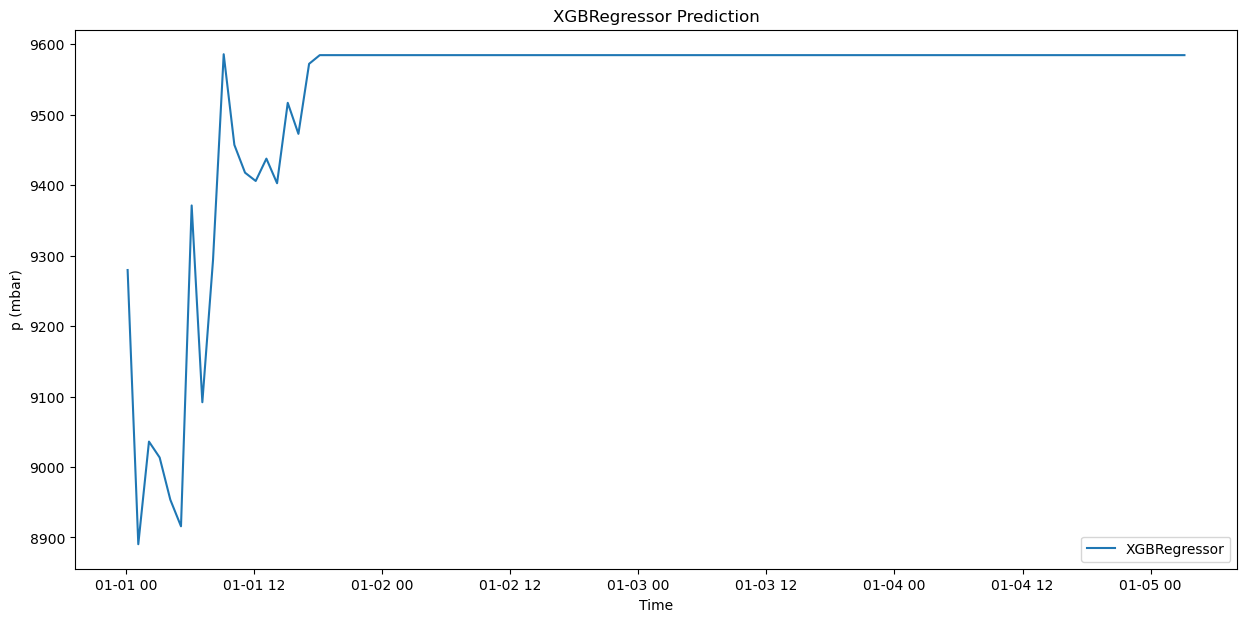

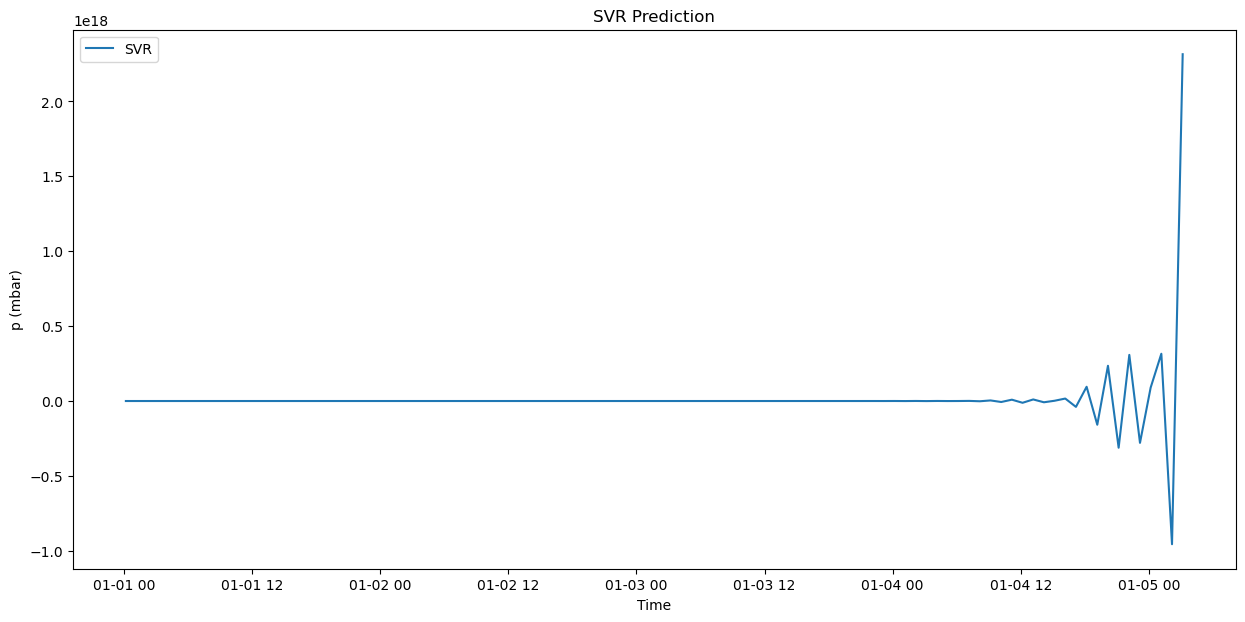

In [24]:
#Load all the models
model_dir = '/Users/nfanlo/dev/technical-test/part2/models'
models = {f.split('.')[0]: pickle.load(open(os.path.join(model_dir, f), 'rb')) for f in os.listdir(model_dir)}

#Predict 100 future steps without knowing the regressor variables
def predict_future(model, X_last, steps=100):
    predictions = []
    current_input = X_last.copy()
    for _ in range(steps):
        pred = model.predict(current_input)
        predictions.append(pred[0])
        current_input = np.append(current_input[:, 1:], pred).reshape(1, -1)
    return predictions

X_last = X_test_scaled[-1].reshape(1, -1)  # Correct shape for model input
y_future = {name: predict_future(model, X_last, 100) for name, model in models.items()}

#Calculate mean and std for y_train
y_train_mean = y_train.mean()
y_train_std = y_train.std()

#Inverse transform the predictions
y_future_transformed = {name: (np.array(pred) * y_train_std + y_train_mean).flatten() for name, pred in y_future.items()}

for name, pred in y_future_transformed.items():
    plt.figure(figsize=(15, 7))
    future_index = pd.date_range(start=y_test.index[-1], periods=len(pred) + 1, freq='H')[1:]
    plt.plot(future_index, pred, label=name)
    plt.xlabel('Time')
    plt.ylabel('p (mbar)')
    plt.title(f'{name} Prediction')
    plt.legend()
    plt.show()

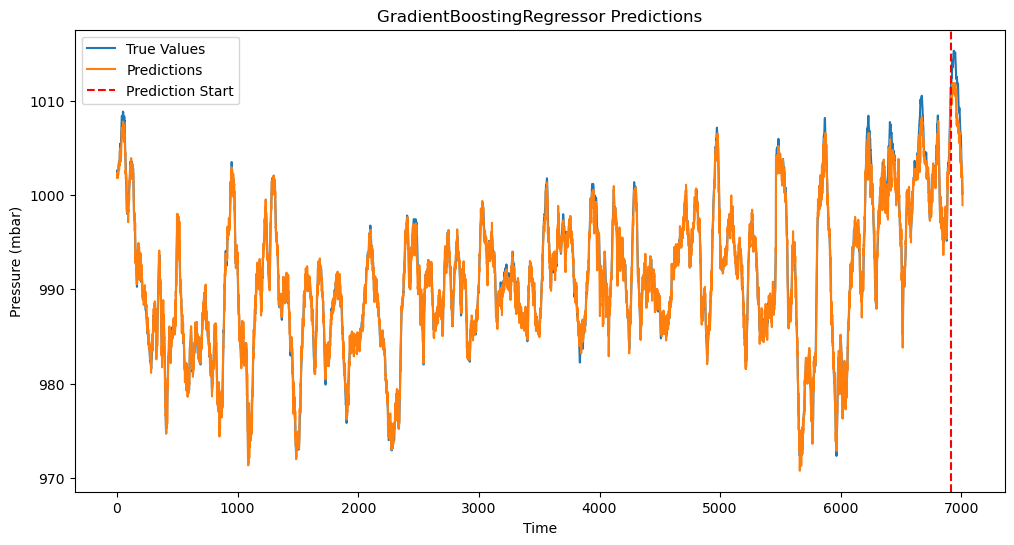

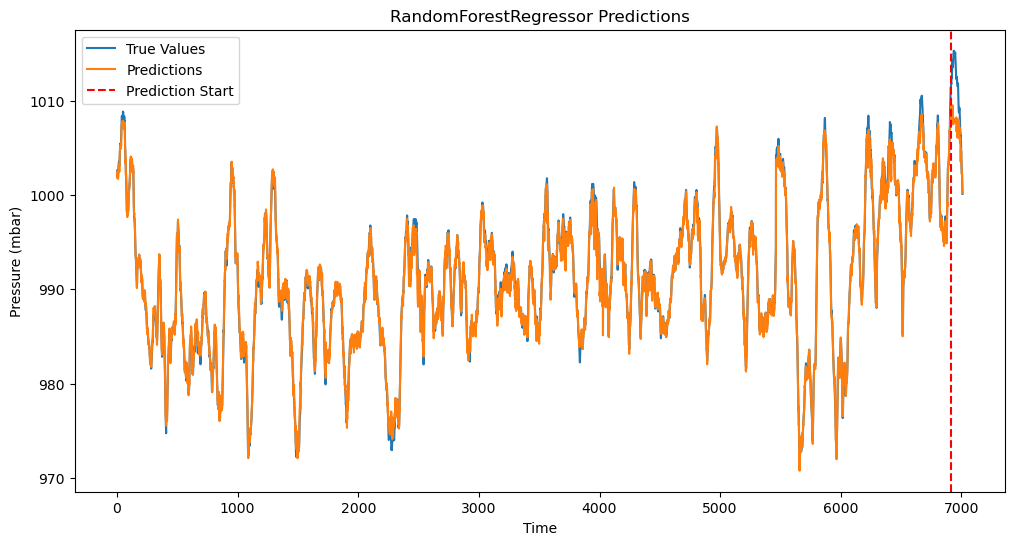

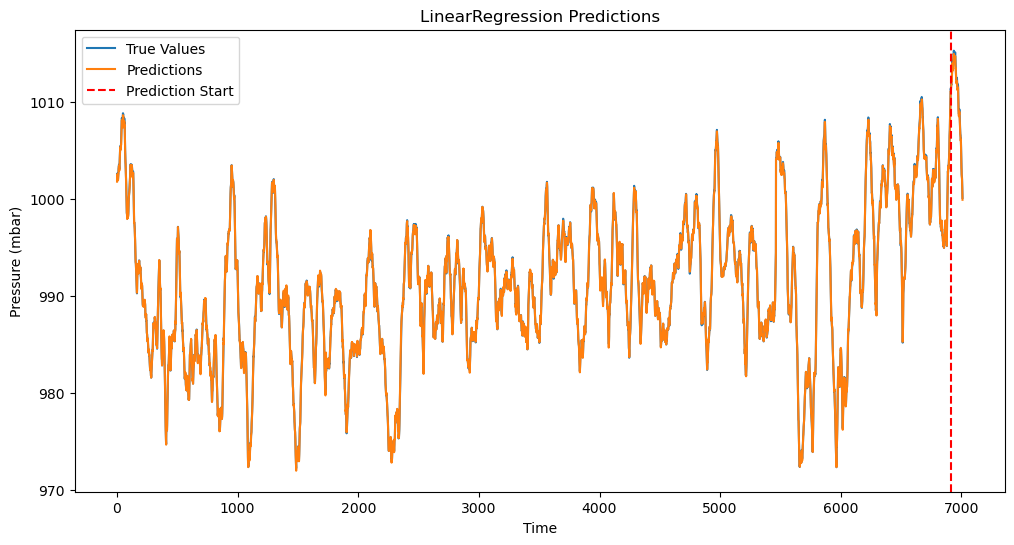

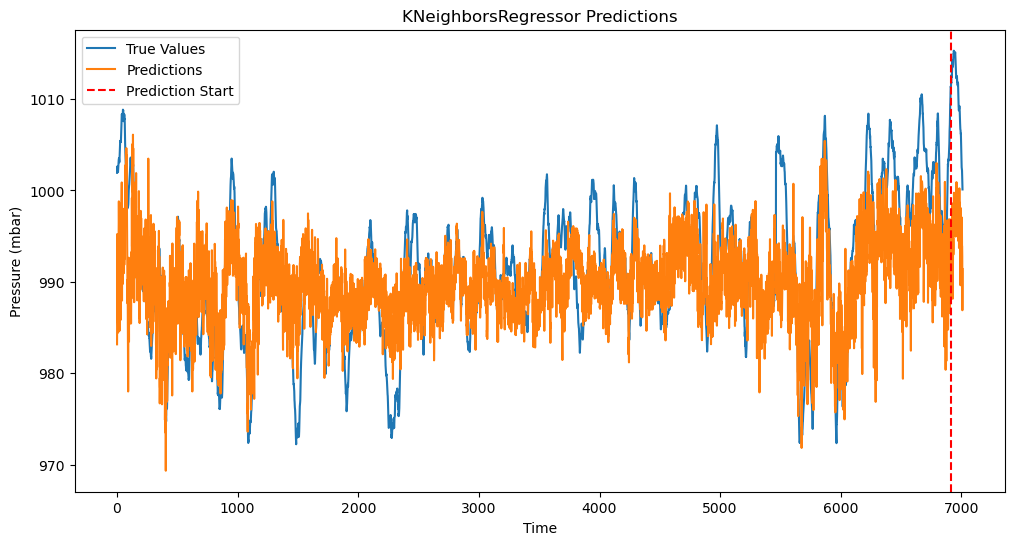

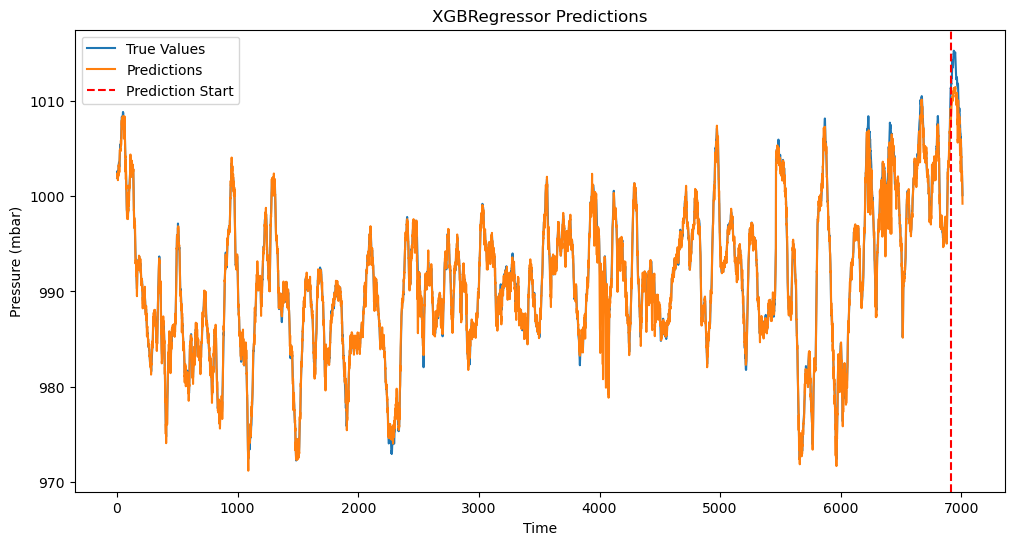

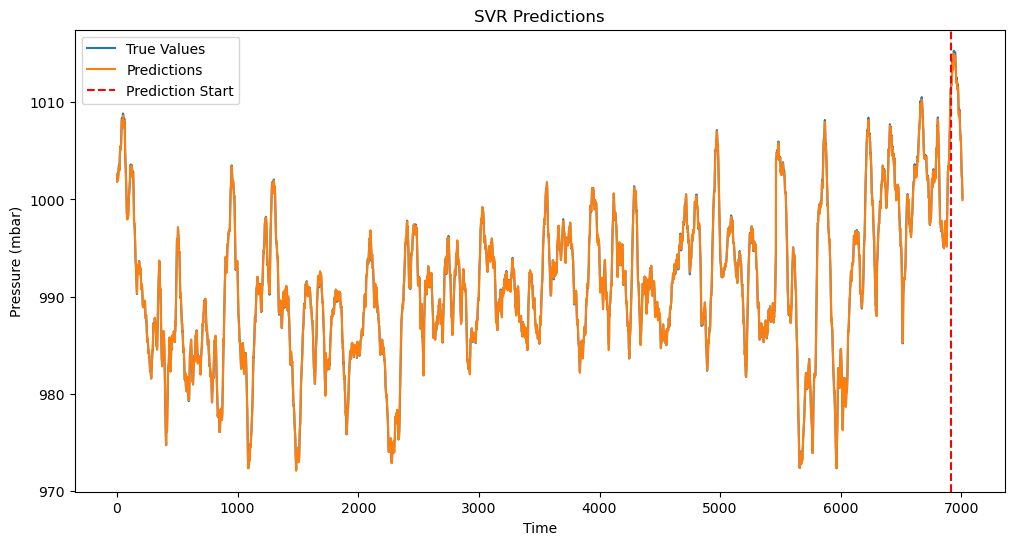

In [30]:
#Make predictions on the entire test series to see the performance of the models
models_dir = '/Users/nfanlo/dev/technical-test/part2/models'
models = {f.split('.')[0]: pickle.load(open(os.path.join(models_dir, f), 'rb')) for f in os.listdir(models_dir)}

#Number of moments of future time to predict
future_steps = 100
predictions = {name: model.predict(X_test_scaled) for name, model in models.items()}

for name, y_pred in predictions.items():
    plt.figure(figsize=(15, 7))
    plt.plot(np.arange(len(y_test)), y_test, label='True Values')
    plt.plot(np.arange(len(y_test)), y_pred, label='Predictions')
    plt.axvline(x=len(y_test)-future_steps, color='red', linestyle='--', label='Prediction Start')
    plt.title(f'{name} Predictions')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.legend()
    plt.show()

### Lets build a LSTM, RNN and CNN models

Epoch 1/100
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - loss: 922413.1875 - mean_absolute_error: 960.2134 - root_mean_squared_error: 960.3472 - val_loss: 818294.6875 - val_mean_absolute_error: 904.5557 - val_root_mean_squared_error: 904.5964 - learning_rate: 0.0010
Epoch 2/100
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - loss: 783473.7500 - mean_absolute_error: 884.9282 - root_mean_squared_error: 885.0800 - val_loss: 693043.2500 - val_mean_absolute_error: 832.4473 - val_root_mean_squared_error: 832.4922 - learning_rate: 0.0010
Epoch 3/100
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 661440.6875 - mean_absolute_error: 812.9901 - root_mean_squared_error: 813.2222 - val_loss: 576919.6250 - val_mean_absolute_error: 759.5030 - val_root_mean_squared_error: 759.5522 - learning_rate: 0.0010
Epoch 4/100
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 548417.1875 - mean_absolute_error: 740.1235 - root_mean_squared_error: 740.4782 - val_loss: 472868.5000 - val_mean_absolute_erro

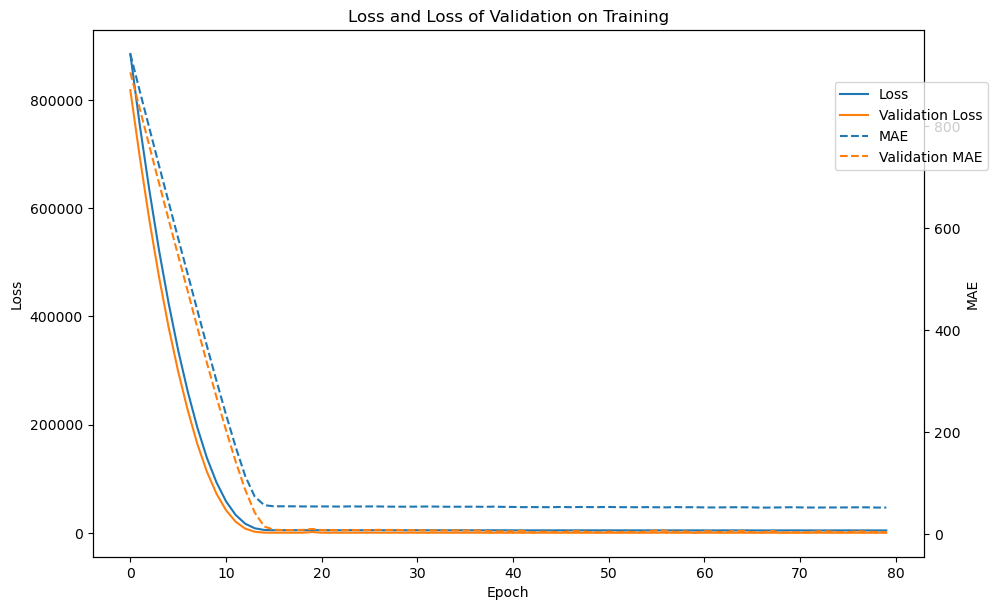

In [82]:
#Function to create sequences for LSTM model
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

#Model construction and training LSTM
def train_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)])
    
    #Adam optimizer, MSE for loss and MAE/RMSE metrics with learning rate 0,001
    #ReduceLronPlateau is introduced to reduce the learning rate during training (after 10 epochs) 
    # and Earlystoping to stop training once training improvements are not obtained (after 20 epochs)
    #The number of epochs is set to 100 and the batch size to 32
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001),
        EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, restore_best_weights=True)]
    
    history = model.fit(X_train_sequences, y_train_sequences, epochs=100, batch_size=32, validation_data=(X_val_sequences, y_val_sequences), callbacks=callbacks)
    return model, history

def plot_training_history(history):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(history.history['loss'], label='Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('MAE')
    ax2.plot(history.history['mean_absolute_error'], label='MAE', linestyle='--')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE', linestyle='--')
    ax2.tick_params(axis='y')

    fig.tight_layout()
    plt.title('Loss and Loss of Validation on Training')
    fig.legend(loc='upper right', bbox_to_anchor=(1,0.9))
    plt.show()

def save_model_and_scaler(model, scaler, model_path, scaler_path):
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

TIME_STEPS = 24
X_train_sequences, y_train_sequences = create_sequences(X_train_scaled, y_train, TIME_STEPS)
X_val_sequences, y_val_sequences = create_sequences(X_val_scaled, y_val, TIME_STEPS)
X_test_sequences, y_test_sequences = create_sequences(X_test_scaled, y_test, TIME_STEPS)

model, history = train_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences)
save_model_and_scaler(model, scaler, '/Users/nfanlo/dev/technical-test/part2/models/lstm_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/lstm_scaler.pkl')
plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━

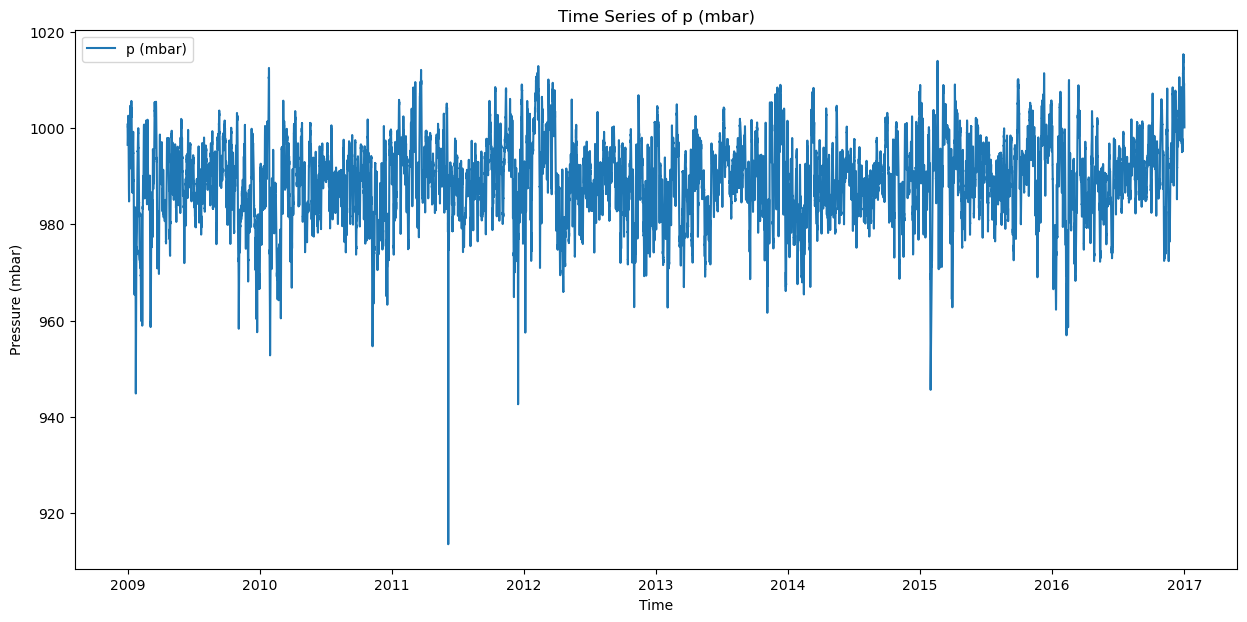

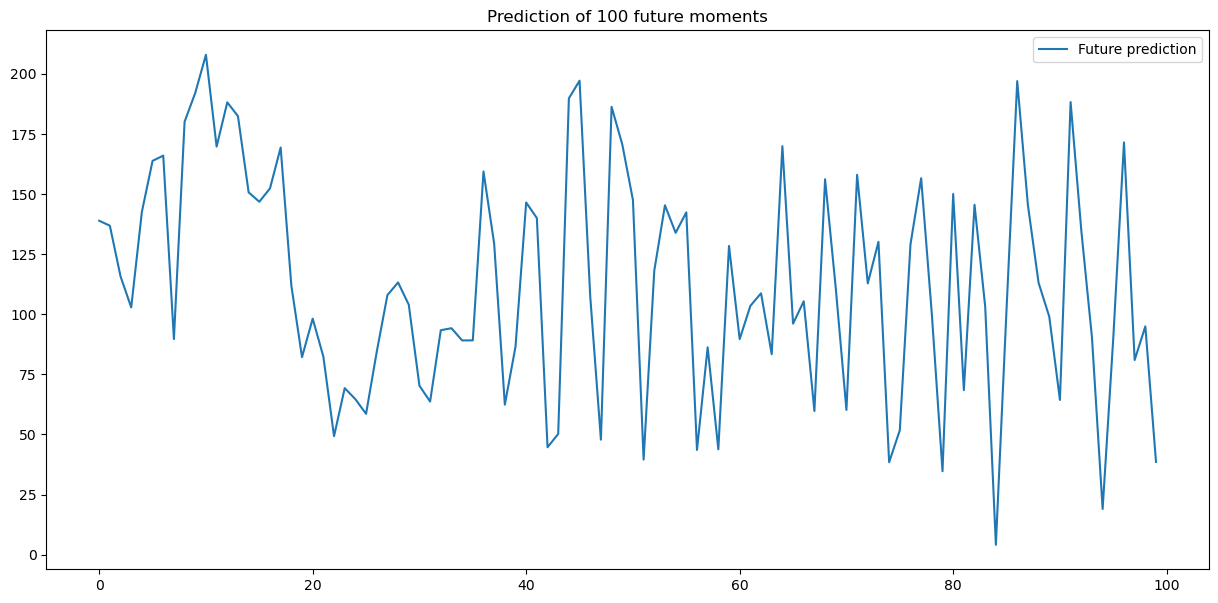

218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
MAE: 3.444581709469711
RMSE: 4.422676220788679


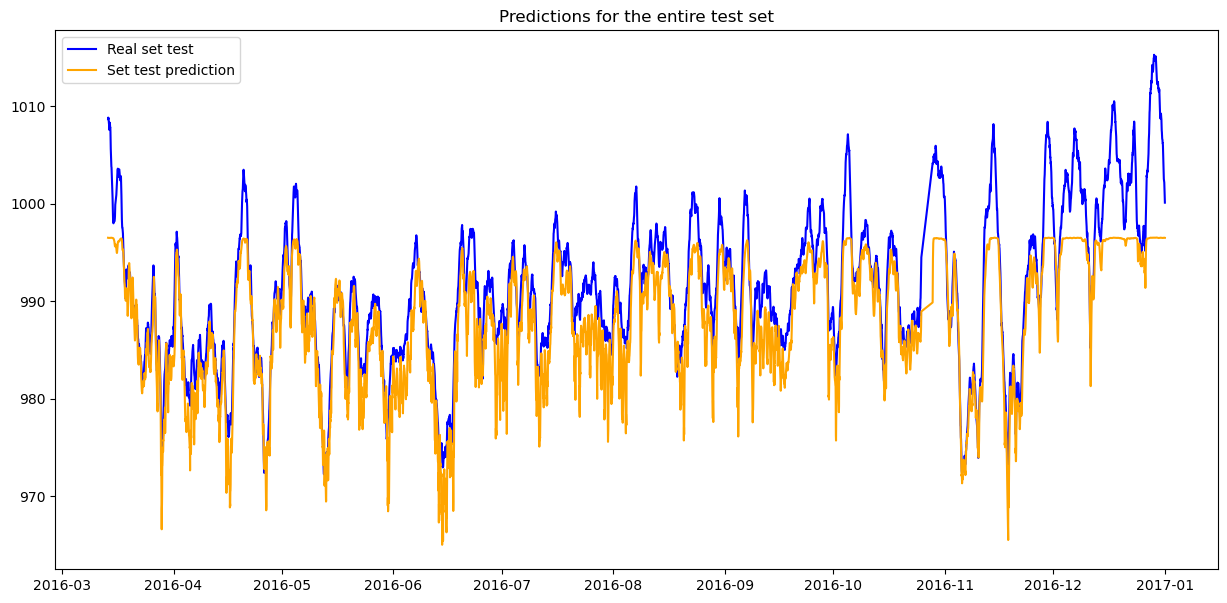

In [101]:
#Load the model and scaler
def load_model_and_scaler(model_path, scaler_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    return model, scaler

#Function to predict of 100 moments
def predict_future(model, last_sequence, steps=100):
    predictions = []
    current_input = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(current_input[:, np.newaxis, :])
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[:, 1:], pred, axis=1)
    return predictions

def plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model):
    
    #Plot the time series of 'p (mbar)' from dataframe
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['p (mbar)'], label='p (mbar)')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.title('Time Series of p (mbar)')
    plt.legend()
    plt.show()

    #Plot the future prediction for 100 steps
    plt.figure(figsize=(15, 7))
    plt.plot(future_predictions, label='Future prediction')
    plt.title('Prediction of 100 future moments')
    plt.legend()
    plt.show()

    test_predictions = model.predict(X_test_sequences).flatten()
    mae = mean_absolute_error(y_test[TIME_STEPS:], test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test[TIME_STEPS:], test_predictions))
    
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    #Plot the prediction for test set
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index[TIME_STEPS:], y_test.values[TIME_STEPS:], label='Real set test', color='blue')
    plt.plot(y_test.index[TIME_STEPS:], test_predictions, label='Set test prediction', color='orange')
    plt.title('Predictions for the entire test set')
    plt.legend()
    plt.show()

model, scaler = load_model_and_scaler('/Users/nfanlo/dev/technical-test/part2/models/lstm_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/scaler.pkl')
last_sequence = X_test_sequences[-1]
future_predictions = predict_future(model, last_sequence, 100)
plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model)


Epoch 1/150
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - loss: 875530.0625 - mean_absolute_error: 934.6142 - root_mean_squared_error: 935.2800 - val_loss: 630050.6250 - val_mean_absolute_error: 793.7100 - val_root_mean_squared_error: 793.7573 - learning_rate: 0.0100
Epoch 2/150
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 561409.8125 - mean_absolute_error: 747.4844 - root_mean_squared_error: 748.8557 - val_loss: 381894.7500 - val_mean_absolute_error: 617.9160 - val_root_mean_squared_error: 617.9763 - learning_rate: 0.0100
Epoch 3/150
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 334025.0312 - mean_absolute_error: 574.0887 - root_mean_squared_error: 577.5099 - val_loss: 205956.6406 - val_mean_absolute_error: 453.7422 - val_root_mean_squared_error: 453.8245 - learning_rate: 0.0100
Epoch 4/150
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 177921.9688 - mean_absolute_error: 413.4006 - root_mean_squared_error: 421.3294 - val_loss: 91630.8516 - val_mean_absolute_error

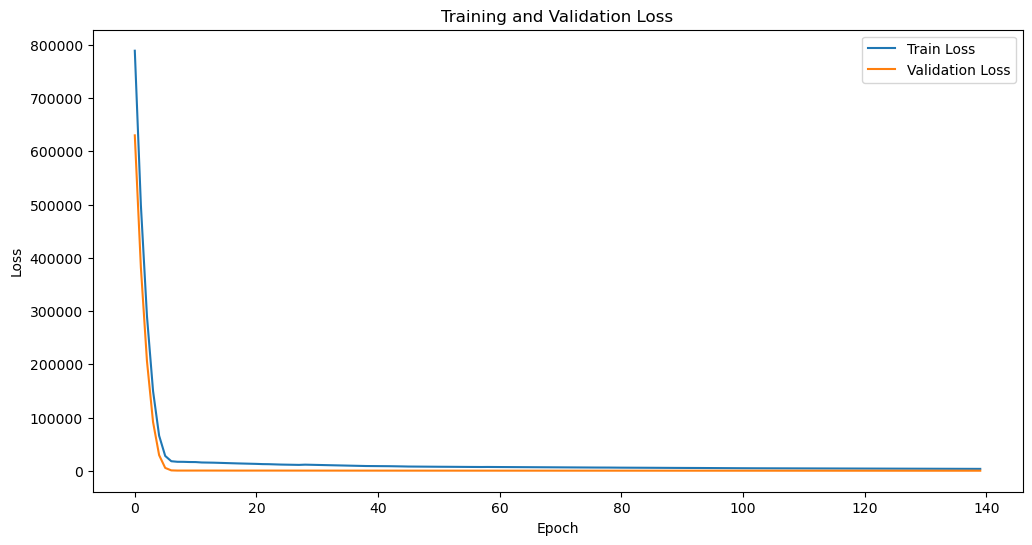

In [123]:
#An attempt to improve the LSTM network. 
# - Time steps of the sequences are increased to 48. 
# - Size of the model layers decreased to 32, because there is a lot of data (70k). the second layer is decreased 
# to 12 for consolidate the learning of the model. 
#We add Ridge regularization (L2) to mitigate multicollinearity identified at the beginning of the notebook but doesn't work well
#Increase epochs to 150 witho earlystopping patience 20


#Model construction and training LSTM
def train_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences):
    model = Sequential([LSTM(32, return_sequences=True, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])),
    Dropout(0.2),
    LSTM(12, return_sequences=False),
    Dropout(0.2),
    Dense(1)])
    
    #Adam optimizer, MSE for loss and MAE/RMSE metrics
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001),
        EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, restore_best_weights=True)]
    
    history = model.fit(X_train_sequences, y_train_sequences, epochs=150, batch_size=32, validation_data=(X_val_sequences, y_val_sequences), callbacks=callbacks)
    return model, history

TIME_STEPS = 48
X_train_sequences, y_train_sequences = create_sequences(X_train_scaled, y_train, TIME_STEPS)
X_val_sequences, y_val_sequences = create_sequences(X_val_scaled, y_val, TIME_STEPS)
X_test_sequences, y_test_sequences = create_sequences(X_test_scaled, y_test, TIME_STEPS)

model, history = train_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences)
save_model_and_scaler(model, scaler, '/Users/nfanlo/dev/technical-test/part2/models/lstm_dense_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/lstm_dense_scaler.pkl')
plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━

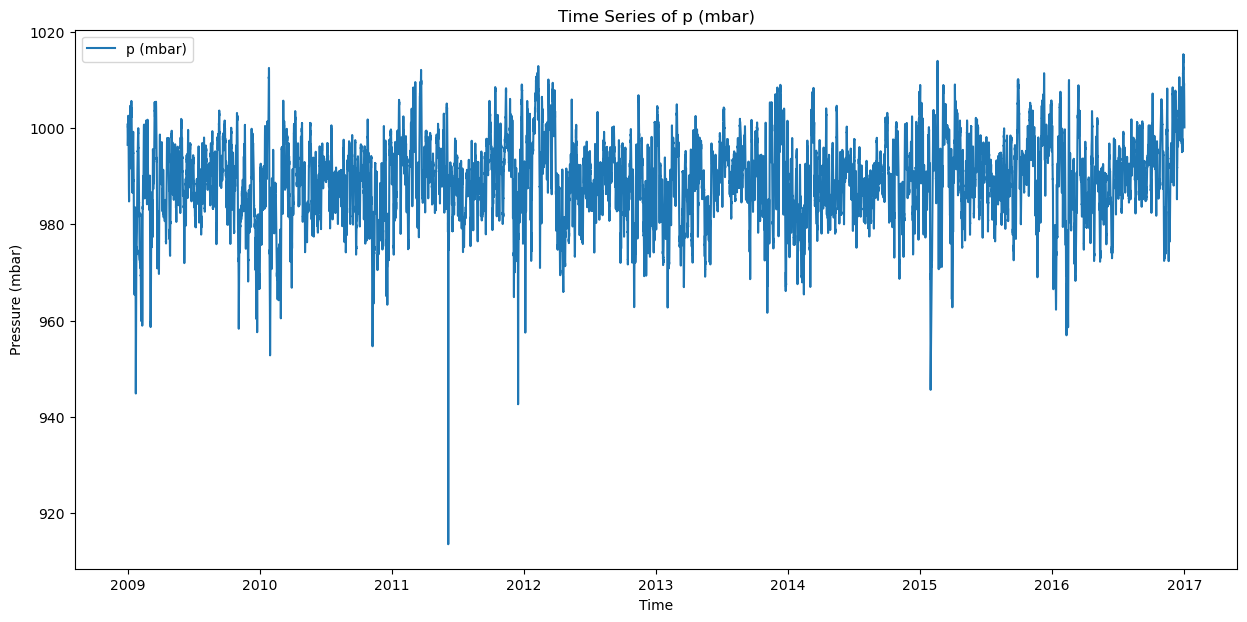

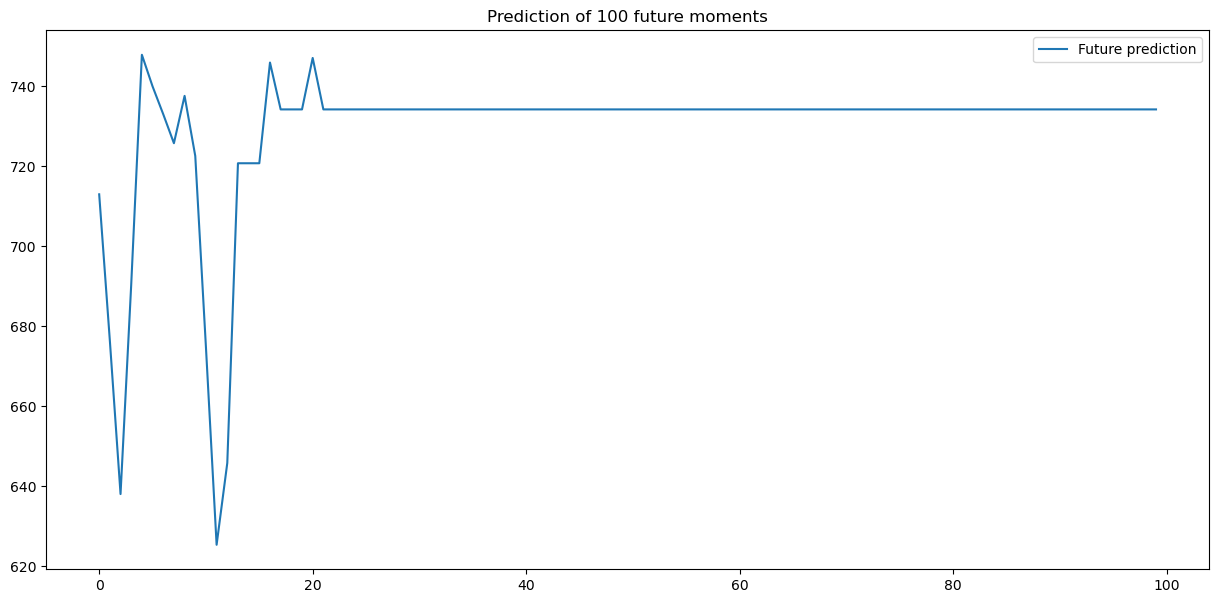

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAE: 9.084068352782293
RMSE: 10.935572239572537


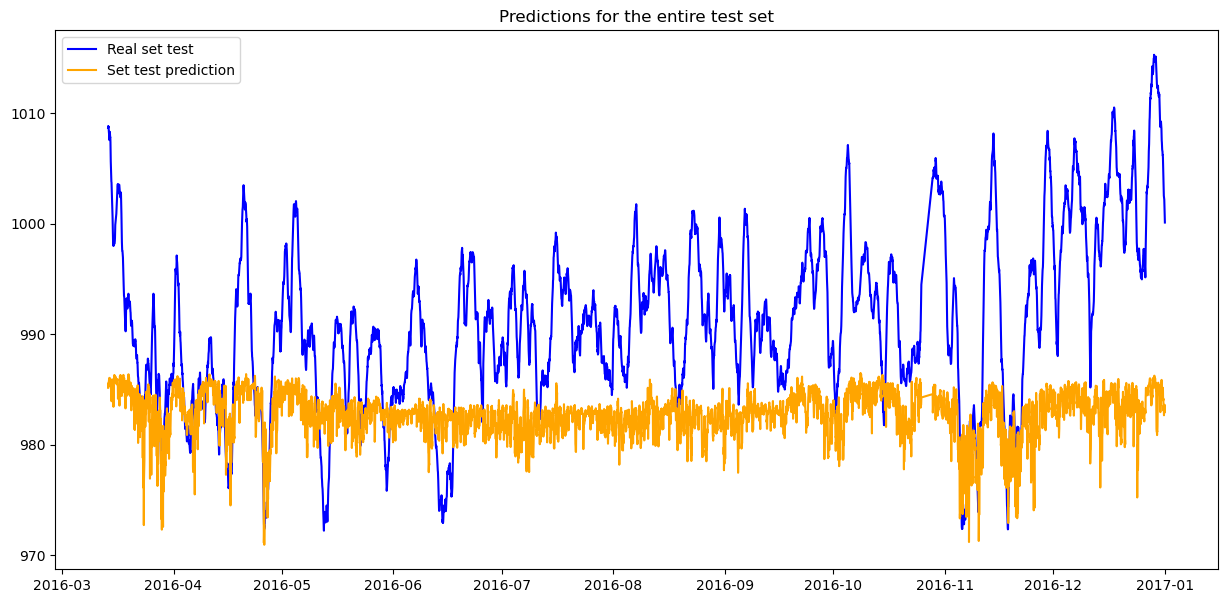

In [124]:
#Function to predict of 100 moments
def predict_future(model, last_sequence, steps=100):
    predictions = []
    current_input = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(current_input[:, np.newaxis, :])
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[:, 1:], pred, axis=1)
    return predictions

# Gráficos y evaluación de las predicciones
def plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model):
    #Plot the time series of 'p (mbar)' from dataframe
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['p (mbar)'], label='p (mbar)')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.title('Time Series of p (mbar)')
    plt.legend()
    plt.show()

    #Plot the future prediction for 100 steps
    plt.figure(figsize=(15, 7))
    plt.plot(future_predictions, label='Future prediction')
    plt.title('Prediction of 100 future moments')
    plt.legend()
    plt.show()

    test_predictions = model.predict(X_test_sequences).flatten()
    mae = mean_absolute_error(y_test[TIME_STEPS:], test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test[TIME_STEPS:], test_predictions))
    
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    #Plot the prediction for test set
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index[TIME_STEPS:], y_test.values[TIME_STEPS:], label='Real set test', color='blue')
    plt.plot(y_test.index[TIME_STEPS:], test_predictions, label='Set test prediction', color='orange')
    plt.title('Predictions for the entire test set')
    plt.legend()
    plt.show()

# Asumiendo que ya tienes tu dataframe `df`
model, scaler = load_model_and_scaler('/Users/nfanlo/dev/technical-test/part2/models/lstm_dense_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/lstm_dense_scaler.pkl')
last_sequence = X_test_sequences[-1]
future_predictions = predict_future(model, last_sequence, 100)
plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model)


Epoch 1/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 945704.9375 - mean_absolute_error: 972.3284 - root_mean_squared_error: 972.4488 - val_loss: 888236.6875 - val_mean_absolute_error: 941.9794 - val_root_mean_squared_error: 942.4626 - learning_rate: 0.0010
Epoch 2/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 862682.0000 - mean_absolute_error: 928.1285 - root_mean_squared_error: 928.7854 - val_loss: 814045.2500 - val_mean_absolute_error: 900.5705 - val_root_mean_squared_error: 902.2427 - learning_rate: 0.0010
Epoch 3/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 786498.5625 - mean_absolute_error: 885.0189 - root_mean_squared_error: 886.8267 - val_loss: 745650.0000 - val_mean_absolute_error: 859.8079 - val_root_mean_squared_error: 863.5060 - learning_rate: 0.0010
Epoch 4/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - loss: 717196.5625 - mean_absolute_error: 843.0942 - root_mean_squared_error: 846.8450 - val_loss: 682255.3750 - val_mean_absolute_erro

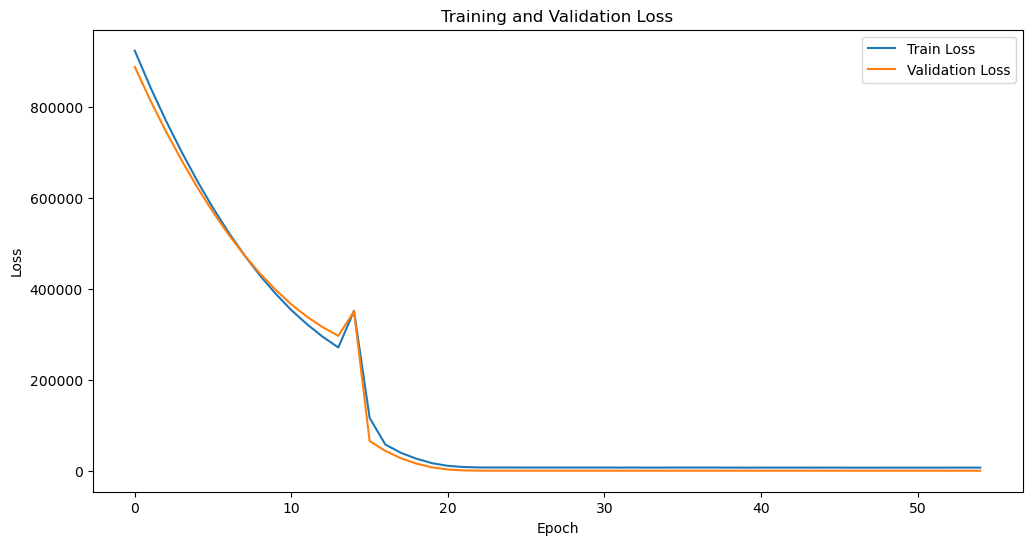

In [125]:
regularizer = l2(l2=0.01)
def train_rnn_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences):
    model = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2])),
        Dropout(0.2),
        SimpleRNN(64, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(32, return_sequences=False),
        Dropout(0.2),
        Dense(1, kernel_regularizer=regularizer)])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001),
                 EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, restore_best_weights=True)]
    
    history = model.fit(X_train_sequences, y_train_sequences, epochs=100, batch_size=32, 
                        validation_data=(X_val_sequences, y_val_sequences), callbacks=callbacks)
    return model, history

def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Assuming you have your data in X_train, y_train, X_val, y_val
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

TIME_STEPS = 48
X_train_sequences, y_train_sequences = create_sequences(X_train_scaled, y_train, TIME_STEPS)
X_val_sequences, y_val_sequences = create_sequences(X_val_scaled, y_val, TIME_STEPS)
X_test_sequences, y_test_sequences = create_sequences(X_test_scaled, y_test, TIME_STEPS)

model, history = train_rnn_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences)
save_model_and_scaler(model, scaler, '/Users/nfanlo/dev/technical-test/part2/models/rnn_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/scaler.pkl')
plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━

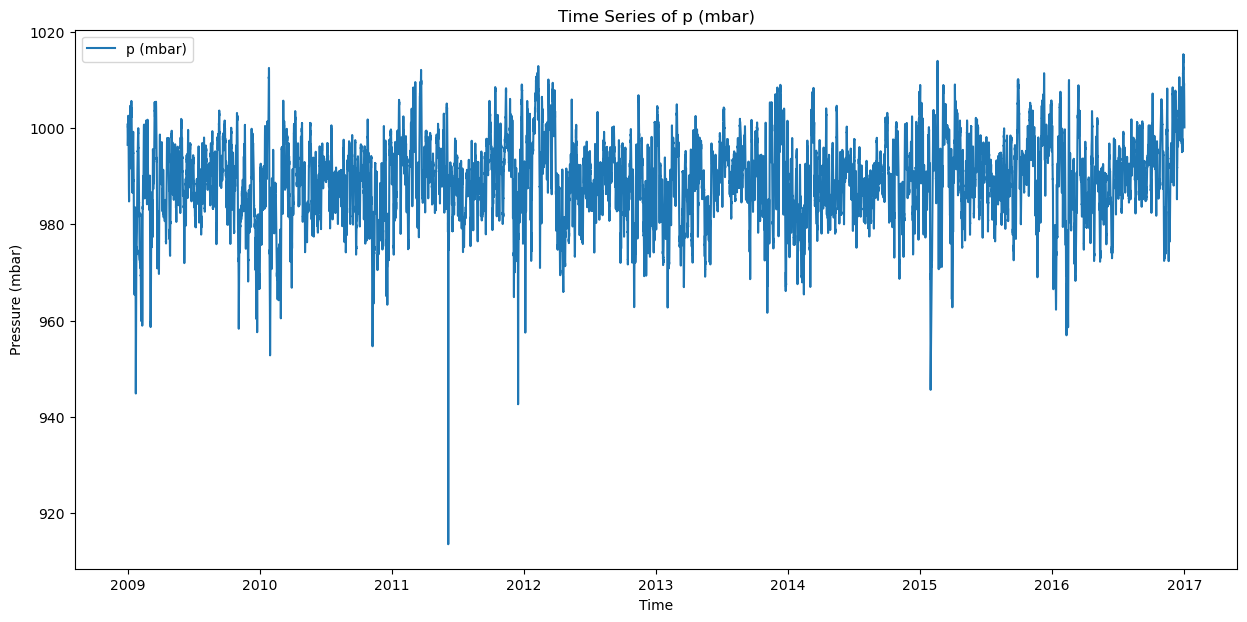

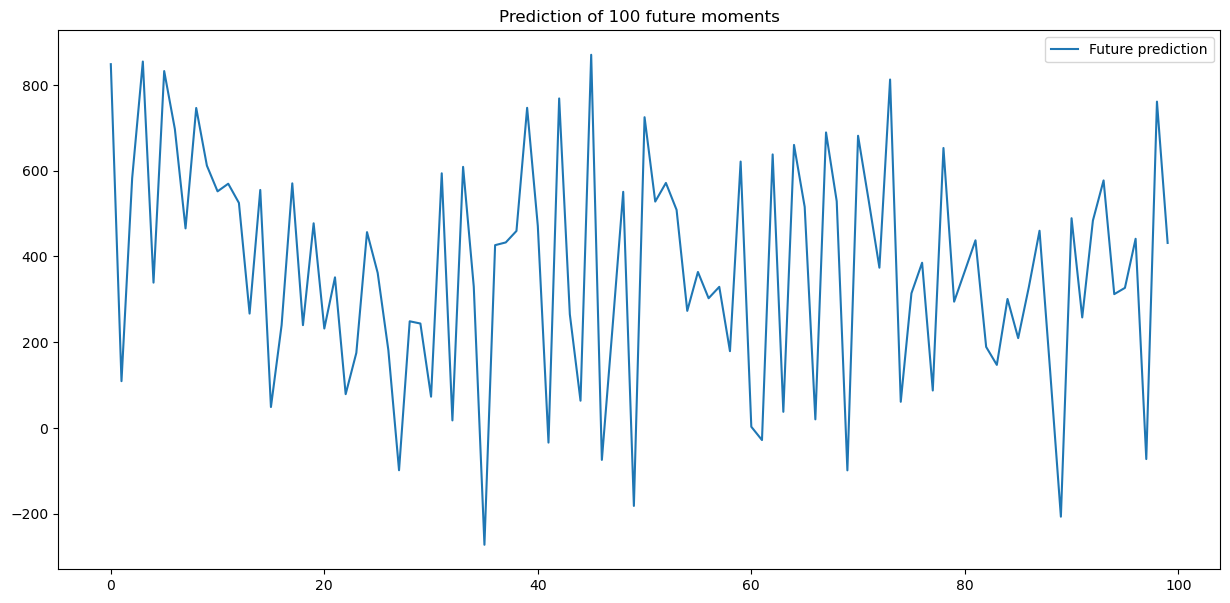

In [127]:
#Function to predict of 100 moments
def predict_future(model, last_sequence, steps=100):
    predictions = []
    current_input = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(current_input[:, np.newaxis, :])
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[:, 1:], pred, axis=1)
    return predictions

def plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model):
    #Plot the time series of 'p (mbar)' from dataframe
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['p (mbar)'], label='p (mbar)')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.title('Time Series of p (mbar)')
    plt.legend()
    plt.show()

    #Plot the future prediction for 100 steps
    plt.figure(figsize=(15, 7))
    plt.plot(future_predictions, label='Future prediction')
    plt.title('Prediction of 100 future moments')
    plt.legend()
    plt.show()

model, scaler = load_model_and_scaler('/Users/nfanlo/dev/technical-test/part2/models/rnn_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/rnn_scaler.pkl')
last_sequence = X_test_sequences[-1]
future_predictions = predict_future(model, last_sequence, 100)
plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model)

Epoch 1/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 95214.1797 - mean_absolute_error: 151.9806 - root_mean_squared_error: 263.2151 - val_loss: 136.3783 - val_mean_absolute_error: 8.4299 - val_root_mean_squared_error: 10.7940 - learning_rate: 0.0010
Epoch 2/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 581.0336 - mean_absolute_error: 18.8782 - root_mean_squared_error: 23.7020 - val_loss: 152.8621 - val_mean_absolute_error: 9.8626 - val_root_mean_squared_error: 11.6245 - learning_rate: 0.0010
Epoch 3/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 542.2001 - mean_absolute_error: 18.2799 - root_mean_squared_error: 22.9086 - val_loss: 115.1546 - val_mean_absolute_error: 8.1232 - val_root_mean_squared_error: 9.8973 - learning_rate: 0.0010
Epoch 4/100
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 541.6055 - mean_absolute_error: 18.2544 - root_mean_squared_error: 22.8972 - val_loss: 92.2561 - val_mean_absolute_error: 7.0264 - val_root_mean_squared_error: 8.

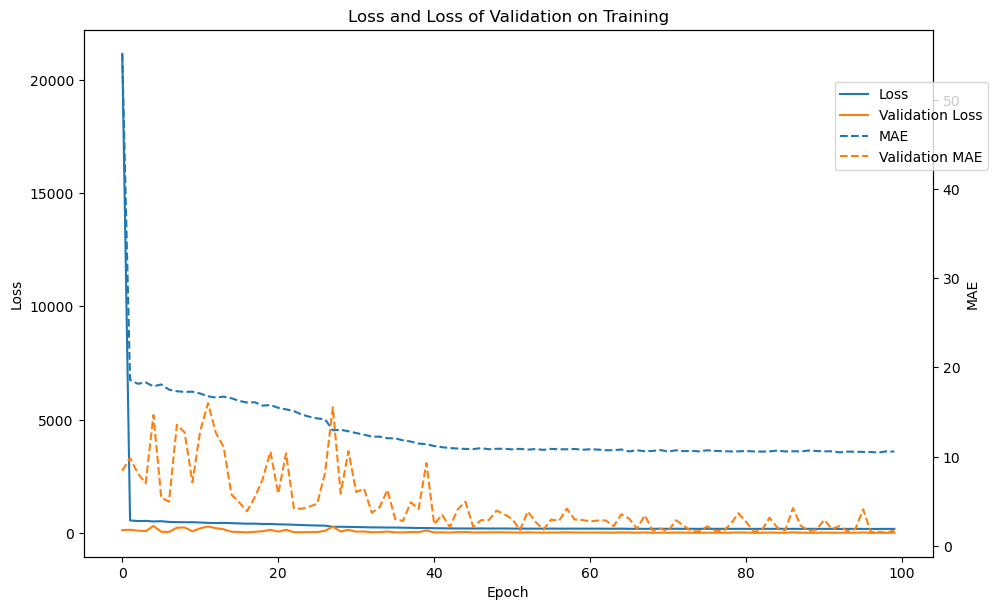

In [88]:
#An CNN model is created maintaining what was applied in the improved LSTM and RNN model
#Add kerner regularizer L2 to mitigate multicollinearity

def train_cnn_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences):
    model = Sequential([Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_sequences.shape[1], X_train_sequences.shape[2]), kernel_regularizer=regularizer),
        Dropout(0.2),
        Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizer),
        Dropout(0.2),
        Flatten(),
        Dense(25, activation='relu', kernel_regularizer=regularizer),
        Dense(1, kernel_regularizer=regularizer)])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
    
    callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001),
        EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, restore_best_weights=True)]
    
    history = model.fit(X_train_sequences, y_train_sequences, epochs=100, batch_size=32, validation_data=(X_val_sequences, y_val_sequences), callbacks=callbacks)
    return model, history

TIME_STEPS = 48
X_train_sequences, y_train_sequences = create_sequences(X_train_scaled, y_train, TIME_STEPS)
X_val_sequences, y_val_sequences = create_sequences(X_val_scaled, y_val, TIME_STEPS)
X_test_sequences, y_test_sequences = create_sequences(X_test_scaled, y_test, TIME_STEPS)

model, history = train_cnn_model(X_train_sequences, y_train_sequences, X_val_sequences, y_val_sequences)
save_model_and_scaler(model, scaler, '/Users/nfanlo/dev/technical-test/part2/models/cnn_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/cnn_scaler.pkl')
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

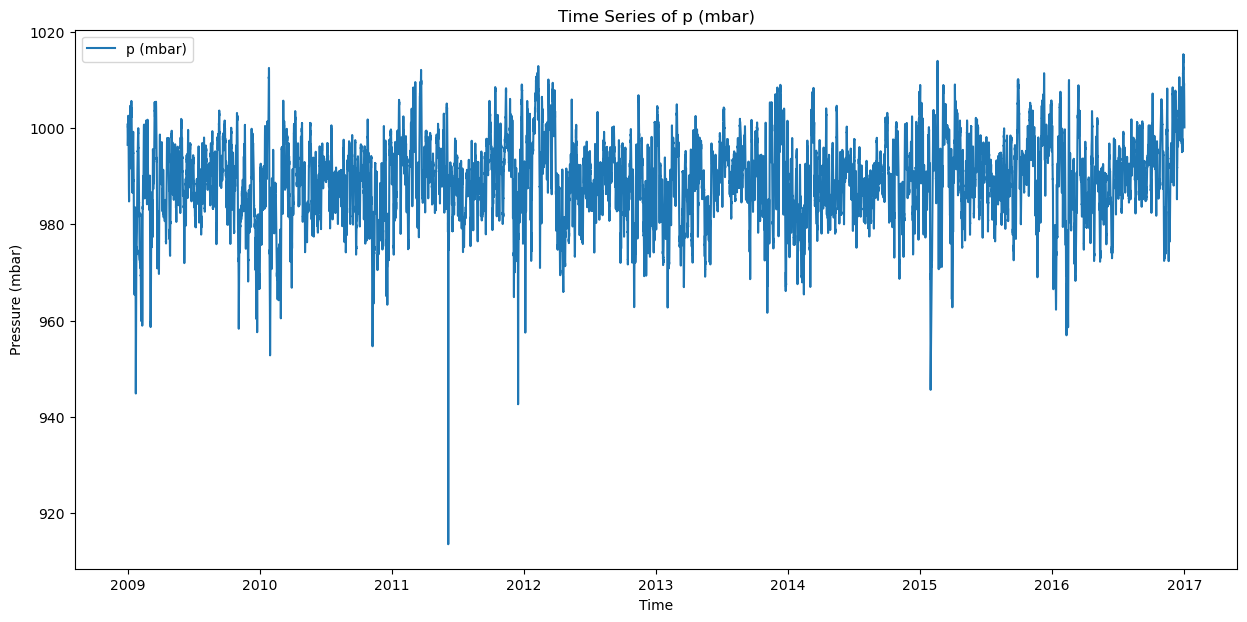

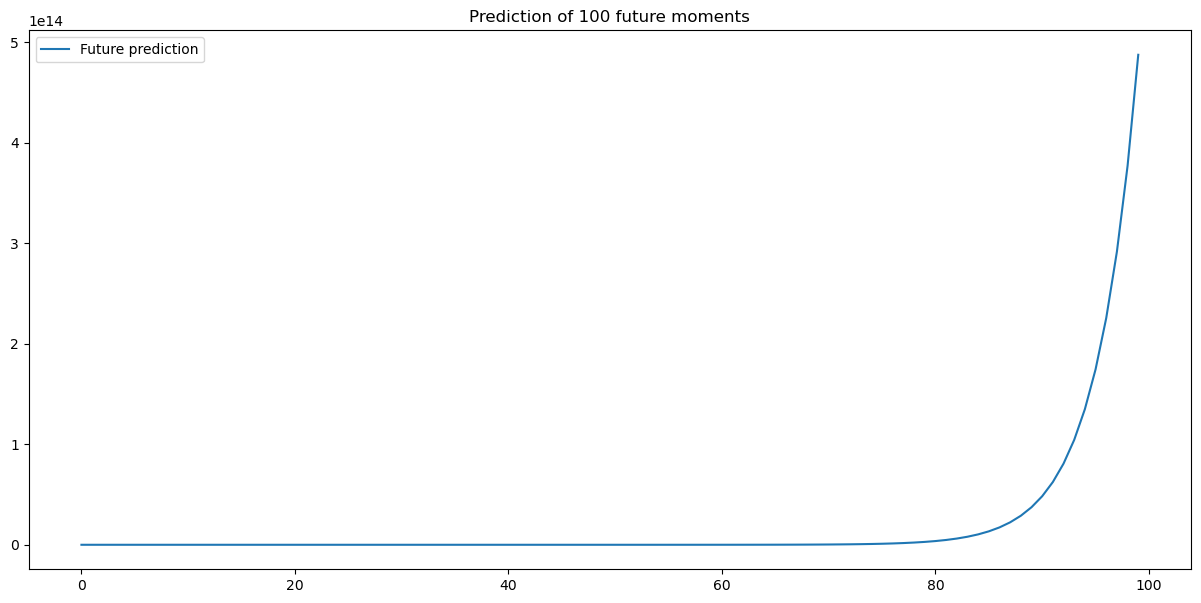

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 1.2431507185771862
RMSE: 1.568304243327482


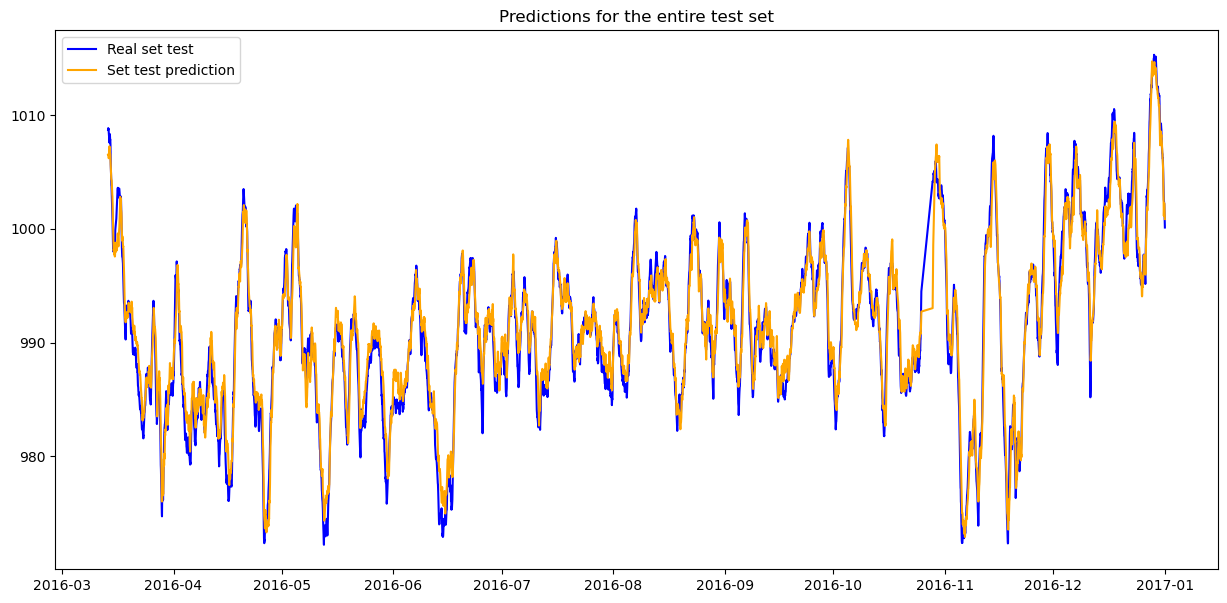

In [104]:
def predict_future(model, last_sequence, steps=100):
    predictions = []
    current_input = last_sequence.copy()
    for _ in range(steps):
        scaled_input = scaler.transform(current_input)
        pred = model.predict(scaled_input[np.newaxis, :, :])
        predictions.append(pred[0, 0])
        new_input = np.zeros_like(current_input[0])  # Crear una nueva entrada con las mismas dimensiones
        new_input[0] = pred[0, 0]  # Asignar la predicción a la primera característica
        current_input = np.vstack([current_input[1:], new_input[np.newaxis, :]])
    return predictions

def plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model):
    #Plot the time series of 'p (mbar)' from dataframe
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['p (mbar)'], label='p (mbar)')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.title('Time Series of p (mbar)')
    plt.legend()
    plt.show()

    #Plot the future prediction for 100 steps
    plt.figure(figsize=(15, 7))
    plt.plot(future_predictions, label='Future prediction')
    plt.title('Prediction of 100 future moments')
    plt.legend()
    plt.show()

    test_predictions = model.predict(X_test_sequences).flatten()
    mae = mean_absolute_error(y_test[TIME_STEPS:], test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test[TIME_STEPS:], test_predictions))
    
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    #Plot the prediction for test set
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index[TIME_STEPS:], y_test.values[TIME_STEPS:], label='Real set test', color='blue')
    plt.plot(y_test.index[TIME_STEPS:], test_predictions, label='Set test prediction', color='orange')
    plt.title('Predictions for the entire test set')
    plt.legend()
    plt.show()

model, scaler = load_model_and_scaler('/Users/nfanlo/dev/technical-test/part2/models/cnn_model.pkl', '/Users/nfanlo/dev/technical-test/part2/models/cnn_scaler.pkl')
last_sequence = X_test_sequences[-1]
future_predictions = predict_future(model, last_sequence, 100)
plot_and_evaluate_predictions(future_predictions, df, y_test, X_test_sequences, model)